In [6]:

import sys
import shap 
import pickle
import sklearn 
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from types import SimpleNamespace




In [7]:



sys.path.append("../")

from dd_package.data.dyslexia_data import DyslexiaData
from dd_package.data.preprocess import preprocess_data

from dd_package.models.regression_estimators import RegressionEstimators

from dd_package.common.utils import save_a_dict, load_a_dict, print_the_evaluated_results

from dd_package.data.preprocess import minmax_standardizer_



In [8]:

configs = {
    "models_path": Path("/home/soroosh/Programmes/DD/Models"),
    "results_path": Path("/home/soroosh/Programmes/DD/Results"),
    "figures_path": Path("/home/soroosh/Programmes/DD/Figures"),
    "params_path": Path("/home/soroosh/Programmes/DD//Params"),
    "n_repeats": 10,
    "n_splits": 5,
}

configs = SimpleNamespace(**configs)



In [9]:

data_name="dd_fix_stats_demo"

estimator_name = "mlp_cls"
to_shuffle = True
to_exclude_at_risk = 0




In [10]:

specifier = data_name + "-" + estimator_name + \
"--shuffled:" + str(to_shuffle) + \
"--exclude at risk:" + str(to_exclude_at_risk)



In [11]:

configs.data_name = data_name



In [12]:

pp = "mm-spec" 

if pp == "mm-spec":
    specifier = specifier + "--pp: " + pp

    
    
configs.specifier = specifier



In [13]:

configs.specifier



'dd_fix_stats_demo-mlp_cls--shuffled:True--exclude at risk:0--pp: mm-spec'

## Load Data

In [14]:


dd = DyslexiaData(path="../../datasets/", n_repeats=5)



In [15]:
data_name

'dd_fix_stats_demo'

In [16]:


if data_name == "dd_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    df_data_to_use = demo_phono.loc[:, [
                                           'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
                                       ]]
    c_features = ['Sex', 'Grade', ]
    indicators = ['SubjectID', ]
    targets = ["Group", "Reading_speed", ]

elif data_name == "dd_fix_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    _ = dd.get_fix_datasets()  # fixes

    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_demo = dd.concat_dfs(
        df1=fix,
        df2=demo_phono,
        features1=fix.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", "Reading_speed", ]
    
elif data_name == "dd_fix":

    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_fix_datasets()  # fixes
    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]

    df_data_to_use = fix
    c_features = None
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", ]

elif data_name == "dd_fix_stats_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    fix_stats = dd.get_fix_stats_dataset()  # fixes

    # concatenate pd.dfs to a pd.df
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix_stats = fix_stats.loc[fix_stats.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_stats_demo = dd.concat_dfs(
        df1=fix_stats,
        df2=demo_phono,
        features1=fix_stats.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_stats_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID',
    ]

    targets = ["Group", "Reading_speed", ]

    
    

Loading Demo data: 
  dyslexia (72, 9)
  norm (213, 9)
  risk (22, 9)
 
Loading Fixation report statistics data: (9071, 10)


In [17]:


data_name



'dd_fix_stats_demo'

In [18]:

df_data_to_use.head()



Group SubjectID  Sentence_ID  Word_Number  FIX_X_mean   FIX_X_std  \
0      1        10            4            8  645.693750  283.247212   
1      1        10            5            8  644.781081  202.020928   
2      1        10            6            9  708.334615  292.435973   
3      1        10            7            8  676.047619  317.074279   
4      1        10            8            8  440.215000  235.935556   

   FIX_Y_mean  FIX_Y_std  FIX_DURATION_mean  FIX_DURATION_std  Sex  Grade  \
0  537.731250   5.683393         147.500000         78.438086    1      4   
1  524.345946   8.486152         180.810811         88.588574    1      4   
2  536.546154   7.099140         187.961538        130.054290    1      4   
3  535.933333   6.465627         179.761905         73.502996    1      4   
4  541.580000   5.290667         201.800000         91.100638    1      4   

   Age  IQ  Reading_speed  
0   10  23          102.0  
1   10  23          102.0  
2   10  23          102.0  
3   10  23          102.0  
4   10  23          102.0

In [19]:
df_data_to_use.shape

(9071, 15)

In [20]:


x_org, y_org = dd.get_onehot_features_targets(
    data=df_data_to_use,
    c_features=c_features,
    indicators=indicators,
    targets=targets,
)



In [21]:

x_org.head()



FIX_X_mean  IQ   FIX_X_std  FIX_Y_std  Age  Grade_5  Sex_2  Grade_6  \
0  645.693750  23  283.247212   5.683393   10        0      0        0   
1  644.781081  23  202.020928   8.486152   10        0      0        0   
2  708.334615  23  292.435973   7.099140   10        0      0        0   
3  676.047619  23  317.074279   6.465627   10        0      0        0   
4  440.215000  23  235.935556   5.290667   10        0      0        0   

   Grade_2  Grade_3  FIX_DURATION_mean  Grade_1  Grade_4  FIX_Y_mean  \
0        0        0         147.500000        0        1  537.731250   
1        0        0         180.810811        0        1  524.345946   
2        0        0         187.961538        0        1  536.546154   
3        0        0         179.761905        0        1  535.933333   
4        0        0         201.800000        0        1  541.580000   

   Word_Number  FIX_DURATION_std  Sex_1  
0            8         78.438086      1  
1            8         88.588574      1  
2            9        130.054290      1  
3            8         73.502996      1  
4            8         91.100638      1

In [22]:

y_org.head()



Group  Reading_speed
0      1          102.0
1      1          102.0
2      1          102.0
3      1          102.0
4      1          102.0

In [23]:


estimator_name = "MLP_cls"

if estimator_name.split("_")[-1] == "reg":
    learning_method = "regression"
    y = y_org.Reading_speed.values

elif estimator_name.split("_")[-1] == "cls":
    learning_method = "classification"
    y = y_org.Group.values

elif estimator_name.split("_")[-1] == "clu":
    from dd_package.models.clustering_estimators import ClusteringEstimators
    y = y_org.Group.values
else:
    assert False, "Undefined algorithm and thus undefined target values"
    
print("learning_method:", learning_method)



learning_method: classification


In [57]:

# x = preprocess_data(x=x_org, pp="mm")  # only x is standardized


# x_df = dd.get_preprocessed_train_test_onehot_features(x_dum=x_org)
# x = x_df.values

x = preprocess_data(x=x_org, pp='mm')  # only x is standardized



pre-processing: mm
Preprocessed data shape: (9071, 17)


In [58]:


features = dd.features
features




['FIX_X_mean',
 'IQ',
 'FIX_X_std',
 'FIX_Y_std',
 'Age',
 'Grade_5',
 'Sex_2',
 'Grade_6',
 'Grade_2',
 'Grade_3',
 'FIX_DURATION_mean',
 'Grade_1',
 'Grade_4',
 'FIX_Y_mean',
 'Word_Number',
 'FIX_DURATION_std',
 'Sex_1']

In [20]:

# data = dd.get_stratified_train_test_splits(
#         x=x, y=y,
#         labels=y_org.Group.values,
#         to_shuffle=to_shuffle,
#         n_splits=10
#     )



# for k, v in data.items():
#     print(k, v['x_train'].shape, v['x_test'].shape,)
    
    

## Load the tuned parameters

In [21]:

tuned_params = load_a_dict(
    name=configs.specifier,
    save_path=configs.params_path
        )
tuned_params



OrderedDict([('activation', 'tanh'),
             ('hidden_layer_sizes', 27),
             ('max_iter', 34339),
             ('solver', 'lbfgs')])

In [25]:


specifier



'dd_fix_stats_demo-mlp_cls--shuffled:True--exclude at risk:0--pp: mm-spec'

In [23]:

mdl = sklearn.neural_network.MLPClassifier(
    activation=tuned_params["activation"], 
    hidden_layer_sizes=tuned_params["hidden_layer_sizes"],
    max_iter=tuned_params["max_iter"],
    solver=tuned_params["solver"],
    verbose=1
)

mdl




MLPClassifier(activation='tanh', hidden_layer_sizes=27, max_iter=34339,
              solver='lbfgs', verbose=1)

In [24]:

# n_s = str(6)
# x_train = data[n_s]["x_train"]
# x_test = data[n_s]["x_test"]
# y_train = data[n_s]["y_train"]
# y_test = data[n_s]["y_test"]


# Using the entire set to train the model, cause we have independent test
idx = np.random.permutation(len(x))

x_train = x[idx, :]
y_train = y[idx]



In [56]:

idx



NameError: name 'idx' is not defined

In [26]:


class_names = ['Norm', 'At-risk', 'Dyslexic']



## Previously obtained results

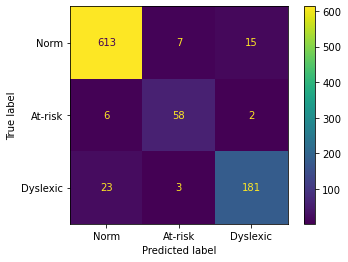

Kappa: 0.8630615102876226 AUC ROC: 0.9834043640479089


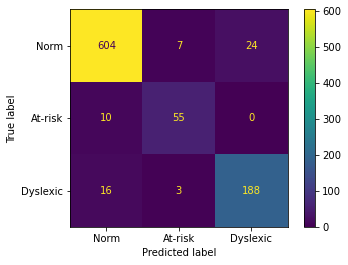

Kappa: 0.8546823680205079 AUC ROC: 0.9807125339457422


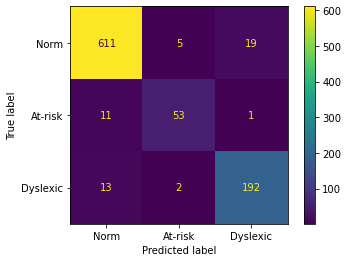

Kappa: 0.8755327736519212 AUC ROC: 0.987638420965078


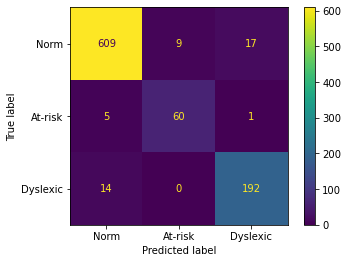

Kappa: 0.8890534629243063 AUC ROC: 0.9863454615183456


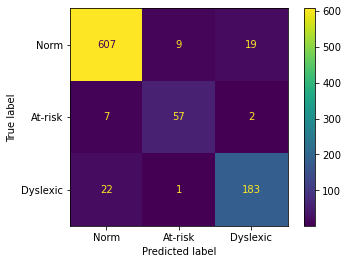

Kappa: 0.8538444391327351 AUC ROC: 0.9823381894225923


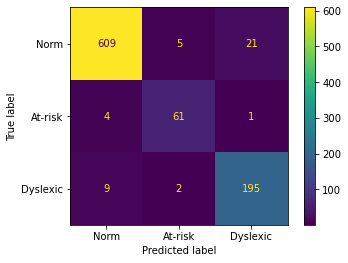

Kappa: 0.8993524250374516 AUC ROC: 0.9893629685916602


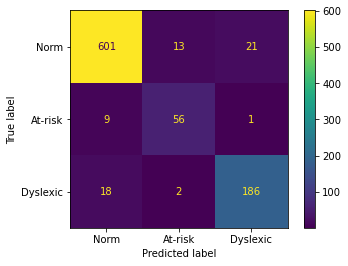

Kappa: 0.8457544475002325 AUC ROC: 0.9825137054319666


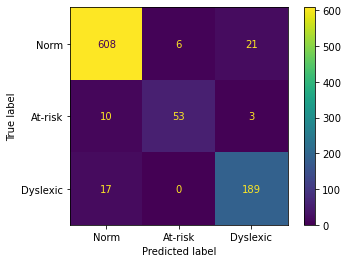

Kappa: 0.8608940621872074 AUC ROC: 0.98330948555894


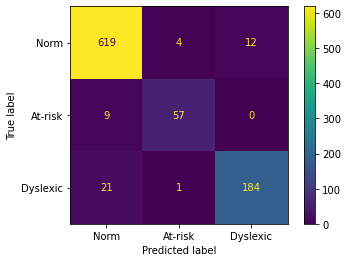

Kappa: 0.8835483218873099 AUC ROC: 0.9884392730119028


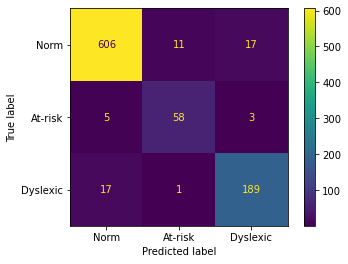

Kappa: 0.869951727763705 AUC ROC: 0.9871912801585697


In [27]:

results = load_a_dict(
    name=configs.specifier,
    save_path=configs.results_path,
        )



for i in range(1, 11):
    i = str(i)
    y_test_ = results[i]["y_test"]
    y_pred_ = results[i]["y_pred"]
    y_prob_ = results[i]["y_pred_prob"]
    
    cm = sklearn.metrics.confusion_matrix(
    y_true=y_test_, 
    y_pred=y_pred_
    )
    
    disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names
                             )
    disp.plot()
    plt.show()
    
    
    print(
        "Kappa:", sklearn.metrics.cohen_kappa_score(y1=y_test_, y2=y_pred_),
        
        "AUC ROC:", sklearn.metrics.roc_auc_score(y_test_, y_prob_,
                                                  multi_class="ovr",
                                                  average="weighted")
    )





In [28]:


print_the_evaluated_results(
    results=results, 
    learning_method=learning_method
)



  ari    nmi  	 preci 	 recall  	 f1_score  	 roc_auc  	 meape  	 jsd  	 acc 	 tnr
 Ave   std  Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std 
0.806 0.022 0.690 0.031 0.941 0.007 0.941 0.007 0.941 0.007 0.985 0.003 1.069 0.087 0.088 0.005 0.941 0.007 0.929 0.013


In [29]:


mdl.fit(x_train, y_train)



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          570     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20042D+00    |proj g|=  4.01991D-01

At iterate    1    f=  1.00270D+00    |proj g|=  2.26434D-01

At iterate    2    f=  8.02131D-01    |proj g|=  1.00904D-01

At iterate    3    f=  7.76579D-01    |proj g|=  6.33145D-02

At iterate    4    f=  7.65298D-01    |proj g|=  1.95881D-02

At iterate    5    f=  7.61583D-01    |proj g|=  1.93989D-02

At iterate    6    f=  7.35669D-01    |proj g|=  2.20654D-02

At iterate    7    f=  7.16464D-01    |proj g|=  1.18163D-02

At iterate    8    f=  7.03404D-01    |proj g|=  1.68905D-02

At iterate    9    f=  6.86934D-01    |proj g|=  1.88973D-02

At iterate   10    f=  6.75714D-01    |proj g|=  1.75945D-02

At iterate   11    f=  6.63710D-01    |proj g|=  1.42232D-02

At iterate   12    f=  6.54396D-01    |proj g|=  2.92146D-02

At iterate   13    f=  6.4

 This problem is unconstrained.



At iterate   39    f=  5.54244D-01    |proj g|=  1.26531D-02

At iterate   40    f=  5.51650D-01    |proj g|=  1.45083D-02

At iterate   41    f=  5.48693D-01    |proj g|=  2.25531D-02

At iterate   42    f=  5.47283D-01    |proj g|=  7.95797D-03

At iterate   43    f=  5.46584D-01    |proj g|=  7.72304D-03

At iterate   44    f=  5.45481D-01    |proj g|=  8.33505D-03

At iterate   45    f=  5.44631D-01    |proj g|=  1.22082D-02

At iterate   46    f=  5.43090D-01    |proj g|=  7.83187D-03

At iterate   47    f=  5.40960D-01    |proj g|=  8.93841D-03

At iterate   48    f=  5.39243D-01    |proj g|=  8.95014D-03

At iterate   49    f=  5.37515D-01    |proj g|=  7.53697D-03

At iterate   50    f=  5.34948D-01    |proj g|=  1.43683D-02

At iterate   51    f=  5.32383D-01    |proj g|=  1.04427D-02

At iterate   52    f=  5.31330D-01    |proj g|=  1.63575D-02

At iterate   53    f=  5.29826D-01    |proj g|=  5.90861D-03

At iterate   54    f=  5.29130D-01    |proj g|=  4.50743D-03

At iter


At iterate  175    f=  3.96219D-01    |proj g|=  1.05306D-02

At iterate  176    f=  3.94933D-01    |proj g|=  1.15251D-02

At iterate  177    f=  3.93715D-01    |proj g|=  6.66330D-03

At iterate  178    f=  3.92932D-01    |proj g|=  4.70274D-03

At iterate  179    f=  3.92149D-01    |proj g|=  4.53630D-03

At iterate  180    f=  3.91688D-01    |proj g|=  8.74839D-03

At iterate  181    f=  3.91226D-01    |proj g|=  4.65117D-03

At iterate  182    f=  3.90821D-01    |proj g|=  7.37924D-03

At iterate  183    f=  3.90473D-01    |proj g|=  9.18617D-03

At iterate  184    f=  3.90076D-01    |proj g|=  6.34272D-03

At iterate  185    f=  3.89183D-01    |proj g|=  5.82457D-03

At iterate  186    f=  3.88709D-01    |proj g|=  4.23112D-03

At iterate  187    f=  3.88379D-01    |proj g|=  9.08076D-03

At iterate  188    f=  3.87805D-01    |proj g|=  4.33942D-03

At iterate  189    f=  3.87154D-01    |proj g|=  5.27362D-03

At iterate  190    f=  3.86200D-01    |proj g|=  7.96497D-03

At iter


At iterate  324    f=  3.25806D-01    |proj g|=  5.84908D-03

At iterate  325    f=  3.25472D-01    |proj g|=  4.03163D-03

At iterate  326    f=  3.25193D-01    |proj g|=  4.28736D-03

At iterate  327    f=  3.24011D-01    |proj g|=  8.37093D-03

At iterate  328    f=  3.23130D-01    |proj g|=  1.23835D-02

At iterate  329    f=  3.22654D-01    |proj g|=  9.59566D-03

At iterate  330    f=  3.22186D-01    |proj g|=  7.42997D-03

At iterate  331    f=  3.21918D-01    |proj g|=  2.67352D-03

At iterate  332    f=  3.21563D-01    |proj g|=  4.25029D-03

At iterate  333    f=  3.20993D-01    |proj g|=  1.44064D-02

At iterate  334    f=  3.20415D-01    |proj g|=  5.76488D-03

At iterate  335    f=  3.20069D-01    |proj g|=  7.45439D-03

At iterate  336    f=  3.19858D-01    |proj g|=  1.02232D-02

At iterate  337    f=  3.19732D-01    |proj g|=  7.20167D-03

At iterate  338    f=  3.19262D-01    |proj g|=  5.88972D-03

At iterate  339    f=  3.18825D-01    |proj g|=  7.02497D-03

At iter


At iterate  457    f=  2.86605D-01    |proj g|=  8.96869D-03

At iterate  458    f=  2.86376D-01    |proj g|=  3.11146D-03

At iterate  459    f=  2.86113D-01    |proj g|=  5.74952D-03

At iterate  460    f=  2.85839D-01    |proj g|=  7.68462D-03

At iterate  461    f=  2.85661D-01    |proj g|=  1.01163D-02

At iterate  462    f=  2.85449D-01    |proj g|=  4.75640D-03

At iterate  463    f=  2.85345D-01    |proj g|=  4.41299D-03

At iterate  464    f=  2.85102D-01    |proj g|=  3.82954D-03

At iterate  465    f=  2.84602D-01    |proj g|=  4.52008D-03

At iterate  466    f=  2.84407D-01    |proj g|=  8.25749D-03

At iterate  467    f=  2.83992D-01    |proj g|=  4.54134D-03

At iterate  468    f=  2.83705D-01    |proj g|=  6.12552D-03

At iterate  469    f=  2.83632D-01    |proj g|=  9.59509D-03

At iterate  470    f=  2.83500D-01    |proj g|=  4.51735D-03

At iterate  471    f=  2.83353D-01    |proj g|=  3.73965D-03

At iterate  472    f=  2.83028D-01    |proj g|=  4.37276D-03

At iter


At iterate  602    f=  2.60453D-01    |proj g|=  4.78338D-03

At iterate  603    f=  2.60393D-01    |proj g|=  1.00906D-02

At iterate  604    f=  2.60195D-01    |proj g|=  8.10691D-03

At iterate  605    f=  2.60009D-01    |proj g|=  3.29423D-03

At iterate  606    f=  2.59863D-01    |proj g|=  3.76188D-03

At iterate  607    f=  2.59757D-01    |proj g|=  3.92554D-03

At iterate  608    f=  2.59501D-01    |proj g|=  3.73188D-03

At iterate  609    f=  2.59301D-01    |proj g|=  4.15317D-03

At iterate  610    f=  2.59207D-01    |proj g|=  2.28348D-02

At iterate  611    f=  2.59039D-01    |proj g|=  7.48829D-03

At iterate  612    f=  2.58947D-01    |proj g|=  2.08945D-03

At iterate  613    f=  2.58854D-01    |proj g|=  3.58080D-03

At iterate  614    f=  2.58664D-01    |proj g|=  6.34622D-03

At iterate  615    f=  2.58421D-01    |proj g|=  4.72612D-03

At iterate  616    f=  2.58332D-01    |proj g|=  7.16229D-03

At iterate  617    f=  2.58186D-01    |proj g|=  2.59542D-03

At iter


At iterate  741    f=  2.34029D-01    |proj g|=  3.71723D-03

At iterate  742    f=  2.33840D-01    |proj g|=  7.67869D-03

At iterate  743    f=  2.33483D-01    |proj g|=  3.49726D-03

At iterate  744    f=  2.33272D-01    |proj g|=  2.94737D-03

At iterate  745    f=  2.33203D-01    |proj g|=  2.27306D-02

At iterate  746    f=  2.32962D-01    |proj g|=  3.51756D-03

At iterate  747    f=  2.32865D-01    |proj g|=  5.32709D-03

At iterate  748    f=  2.32664D-01    |proj g|=  5.90451D-03

At iterate  749    f=  2.32396D-01    |proj g|=  5.85881D-03

At iterate  750    f=  2.32266D-01    |proj g|=  1.08941D-02

At iterate  751    f=  2.31905D-01    |proj g|=  3.42863D-03

At iterate  752    f=  2.31798D-01    |proj g|=  3.15462D-03

At iterate  753    f=  2.31613D-01    |proj g|=  5.29145D-03

At iterate  754    f=  2.31458D-01    |proj g|=  1.05603D-02

At iterate  755    f=  2.31266D-01    |proj g|=  3.47427D-03

At iterate  756    f=  2.31125D-01    |proj g|=  4.18994D-03

At iter


At iterate  888    f=  2.01995D-01    |proj g|=  2.69013D-03

At iterate  889    f=  2.01815D-01    |proj g|=  6.68050D-03

At iterate  890    f=  2.01617D-01    |proj g|=  3.42710D-03

At iterate  891    f=  2.01447D-01    |proj g|=  3.19654D-03

At iterate  892    f=  2.01099D-01    |proj g|=  5.16902D-03

At iterate  893    f=  2.00975D-01    |proj g|=  4.14482D-03

At iterate  894    f=  2.00877D-01    |proj g|=  2.59935D-03

At iterate  895    f=  2.00730D-01    |proj g|=  2.68934D-03

At iterate  896    f=  2.00568D-01    |proj g|=  4.77076D-03

At iterate  897    f=  2.00358D-01    |proj g|=  6.73190D-03

At iterate  898    f=  2.00250D-01    |proj g|=  6.20247D-03

At iterate  899    f=  2.00166D-01    |proj g|=  3.79861D-03

At iterate  900    f=  2.00116D-01    |proj g|=  2.57275D-03

At iterate  901    f=  2.00009D-01    |proj g|=  3.36999D-03

At iterate  902    f=  1.99875D-01    |proj g|=  9.16918D-03

At iterate  903    f=  1.99732D-01    |proj g|=  6.95545D-03

At iter


At iterate 1026    f=  1.81981D-01    |proj g|=  8.84891D-03

At iterate 1027    f=  1.81844D-01    |proj g|=  4.02028D-03

At iterate 1028    f=  1.81762D-01    |proj g|=  1.64011D-03

At iterate 1029    f=  1.81704D-01    |proj g|=  3.21183D-03

At iterate 1030    f=  1.81661D-01    |proj g|=  6.11912D-03

At iterate 1031    f=  1.81569D-01    |proj g|=  3.12908D-03

At iterate 1032    f=  1.81520D-01    |proj g|=  2.07161D-03

At iterate 1033    f=  1.81426D-01    |proj g|=  3.41123D-03

At iterate 1034    f=  1.81384D-01    |proj g|=  7.86358D-03

At iterate 1035    f=  1.81298D-01    |proj g|=  4.67342D-03

At iterate 1036    f=  1.81169D-01    |proj g|=  3.41458D-03

At iterate 1037    f=  1.81029D-01    |proj g|=  4.05390D-03

At iterate 1038    f=  1.80864D-01    |proj g|=  4.92240D-03

At iterate 1039    f=  1.80766D-01    |proj g|=  7.56521D-03

At iterate 1040    f=  1.80535D-01    |proj g|=  3.51303D-03

At iterate 1041    f=  1.80402D-01    |proj g|=  3.56439D-03

At iter


At iterate 1162    f=  1.68702D-01    |proj g|=  4.60873D-03

At iterate 1163    f=  1.68659D-01    |proj g|=  2.60349D-03

At iterate 1164    f=  1.68570D-01    |proj g|=  2.53911D-03

At iterate 1165    f=  1.68500D-01    |proj g|=  4.11482D-03

At iterate 1166    f=  1.68413D-01    |proj g|=  5.08000D-03

At iterate 1167    f=  1.68334D-01    |proj g|=  3.01354D-03

At iterate 1168    f=  1.68293D-01    |proj g|=  1.31201D-03

At iterate 1169    f=  1.68228D-01    |proj g|=  1.83059D-03

At iterate 1170    f=  1.68211D-01    |proj g|=  7.64954D-03

At iterate 1171    f=  1.68174D-01    |proj g|=  6.12128D-03

At iterate 1172    f=  1.68080D-01    |proj g|=  2.18152D-03

At iterate 1173    f=  1.68006D-01    |proj g|=  3.21694D-03

At iterate 1174    f=  1.67931D-01    |proj g|=  3.06467D-03

At iterate 1175    f=  1.67889D-01    |proj g|=  8.82953D-03

At iterate 1176    f=  1.67820D-01    |proj g|=  4.27250D-03

At iterate 1177    f=  1.67759D-01    |proj g|=  2.13535D-03

At iter


At iterate 1315    f=  1.58409D-01    |proj g|=  1.08844D-02

At iterate 1316    f=  1.58353D-01    |proj g|=  6.37498D-03

At iterate 1317    f=  1.58286D-01    |proj g|=  1.93640D-03

At iterate 1318    f=  1.58232D-01    |proj g|=  2.07984D-03

At iterate 1319    f=  1.58193D-01    |proj g|=  1.91448D-03

At iterate 1320    f=  1.58115D-01    |proj g|=  1.71042D-03

At iterate 1321    f=  1.58053D-01    |proj g|=  4.94221D-03

At iterate 1322    f=  1.57999D-01    |proj g|=  3.59489D-03

At iterate 1323    f=  1.57950D-01    |proj g|=  2.62273D-03

At iterate 1324    f=  1.57910D-01    |proj g|=  2.06202D-03

At iterate 1325    f=  1.57846D-01    |proj g|=  2.04655D-03

At iterate 1326    f=  1.57796D-01    |proj g|=  7.50100D-03

At iterate 1327    f=  1.57711D-01    |proj g|=  2.79445D-03

At iterate 1328    f=  1.57667D-01    |proj g|=  3.72230D-03

At iterate 1329    f=  1.57626D-01    |proj g|=  2.12461D-03

At iterate 1330    f=  1.57584D-01    |proj g|=  2.47263D-03

At iter


At iterate 1451    f=  1.52508D-01    |proj g|=  1.21173D-03

At iterate 1452    f=  1.52466D-01    |proj g|=  1.25273D-03

At iterate 1453    f=  1.52429D-01    |proj g|=  3.97858D-03

At iterate 1454    f=  1.52371D-01    |proj g|=  1.92436D-03

At iterate 1455    f=  1.52337D-01    |proj g|=  1.28560D-03

At iterate 1456    f=  1.52314D-01    |proj g|=  4.71733D-03

At iterate 1457    f=  1.52287D-01    |proj g|=  1.90857D-03

At iterate 1458    f=  1.52256D-01    |proj g|=  1.18335D-03

At iterate 1459    f=  1.52236D-01    |proj g|=  1.08259D-02

At iterate 1460    f=  1.52203D-01    |proj g|=  5.53926D-03

At iterate 1461    f=  1.52184D-01    |proj g|=  1.88971D-03

At iterate 1462    f=  1.52170D-01    |proj g|=  1.22091D-03

At iterate 1463    f=  1.52153D-01    |proj g|=  2.01759D-03

At iterate 1464    f=  1.52121D-01    |proj g|=  2.80854D-03

At iterate 1465    f=  1.52075D-01    |proj g|=  3.26320D-03

At iterate 1466    f=  1.52046D-01    |proj g|=  3.03657D-03

At iter


At iterate 1588    f=  1.48803D-01    |proj g|=  6.16903D-03

At iterate 1589    f=  1.48784D-01    |proj g|=  2.81558D-03

At iterate 1590    f=  1.48755D-01    |proj g|=  2.70473D-03

At iterate 1591    f=  1.48725D-01    |proj g|=  5.60947D-03

At iterate 1592    f=  1.48684D-01    |proj g|=  5.40812D-03

At iterate 1593    f=  1.48611D-01    |proj g|=  7.06819D-03

At iterate 1594    f=  1.48568D-01    |proj g|=  3.63982D-03

At iterate 1595    f=  1.48521D-01    |proj g|=  1.75362D-03

At iterate 1596    f=  1.48510D-01    |proj g|=  1.38730D-02

At iterate 1597    f=  1.48471D-01    |proj g|=  6.01258D-03

At iterate 1598    f=  1.48452D-01    |proj g|=  2.50855D-03

At iterate 1599    f=  1.48424D-01    |proj g|=  2.50981D-03

At iterate 1600    f=  1.48404D-01    |proj g|=  2.81779D-03

At iterate 1601    f=  1.48364D-01    |proj g|=  1.33036D-02

At iterate 1602    f=  1.48313D-01    |proj g|=  2.84290D-03

At iterate 1603    f=  1.48292D-01    |proj g|=  1.17929D-03

At iter

At iterate 1728    f=  1.44474D-01    |proj g|=  1.24653D-03

At iterate 1729    f=  1.44454D-01    |proj g|=  3.20341D-03

At iterate 1730    f=  1.44421D-01    |proj g|=  4.93346D-03

At iterate 1731    f=  1.44362D-01    |proj g|=  6.58477D-03

At iterate 1732    f=  1.44335D-01    |proj g|=  4.70514D-03

At iterate 1733    f=  1.44289D-01    |proj g|=  1.98243D-03

At iterate 1734    f=  1.44260D-01    |proj g|=  4.93900D-03

At iterate 1735    f=  1.44227D-01    |proj g|=  4.18961D-03

At iterate 1736    f=  1.44165D-01    |proj g|=  3.16034D-03

At iterate 1737    f=  1.44133D-01    |proj g|=  7.68951D-03

At iterate 1738    f=  1.44101D-01    |proj g|=  1.70177D-03

At iterate 1739    f=  1.44088D-01    |proj g|=  1.18519D-03

At iterate 1740    f=  1.44071D-01    |proj g|=  1.49363D-03

At iterate 1741    f=  1.44034D-01    |proj g|=  3.62039D-03

At iterate 1742    f=  1.44004D-01    |proj g|=  2.91509D-03

At iterate 1743    f=  1.43986D-01    |proj g|=  2.47335D-03

At itera


At iterate 1876    f=  1.39550D-01    |proj g|=  2.28673D-03

At iterate 1877    f=  1.39533D-01    |proj g|=  1.78070D-03

At iterate 1878    f=  1.39505D-01    |proj g|=  3.05825D-03

At iterate 1879    f=  1.39464D-01    |proj g|=  3.30031D-03

At iterate 1880    f=  1.39429D-01    |proj g|=  3.26541D-03

At iterate 1881    f=  1.39406D-01    |proj g|=  1.47872D-02

At iterate 1882    f=  1.39375D-01    |proj g|=  3.07426D-03

At iterate 1883    f=  1.39362D-01    |proj g|=  2.41857D-03

At iterate 1884    f=  1.39350D-01    |proj g|=  4.65263D-03

At iterate 1885    f=  1.39325D-01    |proj g|=  4.86584D-03

At iterate 1886    f=  1.39304D-01    |proj g|=  1.04315D-02

At iterate 1887    f=  1.39233D-01    |proj g|=  4.51293D-03

At iterate 1888    f=  1.39203D-01    |proj g|=  1.56678D-03

At iterate 1889    f=  1.39174D-01    |proj g|=  2.09578D-03

At iterate 1890    f=  1.39149D-01    |proj g|=  1.91203D-03

At iterate 1891    f=  1.39113D-01    |proj g|=  8.69889D-03

At iter


At iterate 2009    f=  1.34831D-01    |proj g|=  1.26715D-03

At iterate 2010    f=  1.34801D-01    |proj g|=  2.12208D-03

At iterate 2011    f=  1.34762D-01    |proj g|=  5.94515D-03

At iterate 2012    f=  1.34745D-01    |proj g|=  4.84020D-03

At iterate 2013    f=  1.34723D-01    |proj g|=  2.07230D-03

At iterate 2014    f=  1.34685D-01    |proj g|=  1.88781D-03

At iterate 2015    f=  1.34636D-01    |proj g|=  3.21744D-03

At iterate 2016    f=  1.34596D-01    |proj g|=  5.85481D-03

At iterate 2017    f=  1.34543D-01    |proj g|=  2.02210D-03

At iterate 2018    f=  1.34522D-01    |proj g|=  1.92548D-03

At iterate 2019    f=  1.34516D-01    |proj g|=  1.10236D-02

At iterate 2020    f=  1.34493D-01    |proj g|=  2.82603D-03

At iterate 2021    f=  1.34480D-01    |proj g|=  3.32770D-03

At iterate 2022    f=  1.34456D-01    |proj g|=  5.35474D-03

At iterate 2023    f=  1.34435D-01    |proj g|=  3.56721D-03

At iterate 2024    f=  1.34422D-01    |proj g|=  8.45346D-03

At iter


At iterate 2152    f=  1.30972D-01    |proj g|=  1.35756D-03

At iterate 2153    f=  1.30955D-01    |proj g|=  2.16175D-03

At iterate 2154    f=  1.30919D-01    |proj g|=  3.34028D-03

At iterate 2155    f=  1.30895D-01    |proj g|=  6.81684D-03

At iterate 2156    f=  1.30855D-01    |proj g|=  1.32091D-03

At iterate 2157    f=  1.30835D-01    |proj g|=  1.05672D-03

At iterate 2158    f=  1.30823D-01    |proj g|=  7.24070D-03

At iterate 2159    f=  1.30806D-01    |proj g|=  2.06006D-03

At iterate 2160    f=  1.30796D-01    |proj g|=  1.72565D-03

At iterate 2161    f=  1.30781D-01    |proj g|=  2.77752D-03

At iterate 2162    f=  1.30764D-01    |proj g|=  9.30996D-03

At iterate 2163    f=  1.30733D-01    |proj g|=  5.60996D-03

At iterate 2164    f=  1.30699D-01    |proj g|=  2.13991D-03

At iterate 2165    f=  1.30668D-01    |proj g|=  2.50675D-03

At iterate 2166    f=  1.30647D-01    |proj g|=  2.97952D-03

At iterate 2167    f=  1.30610D-01    |proj g|=  5.51105D-03

At iter


At iterate 2293    f=  1.28633D-01    |proj g|=  1.41479D-03

At iterate 2294    f=  1.28624D-01    |proj g|=  7.13677D-03

At iterate 2295    f=  1.28612D-01    |proj g|=  3.58620D-03

At iterate 2296    f=  1.28599D-01    |proj g|=  1.38235D-03

At iterate 2297    f=  1.28588D-01    |proj g|=  2.08273D-03

At iterate 2298    f=  1.28581D-01    |proj g|=  9.78407D-03

At iterate 2299    f=  1.28567D-01    |proj g|=  4.39570D-03

At iterate 2300    f=  1.28556D-01    |proj g|=  1.13463D-03

At iterate 2301    f=  1.28548D-01    |proj g|=  2.51214D-03

At iterate 2302    f=  1.28538D-01    |proj g|=  2.45390D-03

At iterate 2303    f=  1.28516D-01    |proj g|=  3.93135D-03

At iterate 2304    f=  1.28502D-01    |proj g|=  2.96169D-03

At iterate 2305    f=  1.28491D-01    |proj g|=  1.10720D-03

At iterate 2306    f=  1.28484D-01    |proj g|=  2.51641D-03

At iterate 2307    f=  1.28474D-01    |proj g|=  3.81228D-03

At iterate 2308    f=  1.28458D-01    |proj g|=  3.56988D-03

At iter


At iterate 2428    f=  1.26663D-01    |proj g|=  1.43529D-03

At iterate 2429    f=  1.26652D-01    |proj g|=  8.23885D-04

At iterate 2430    f=  1.26648D-01    |proj g|=  5.95493D-03

At iterate 2431    f=  1.26638D-01    |proj g|=  3.45544D-03

At iterate 2432    f=  1.26624D-01    |proj g|=  1.25884D-03

At iterate 2433    f=  1.26599D-01    |proj g|=  1.78749D-03

At iterate 2434    f=  1.26578D-01    |proj g|=  2.08114D-03

At iterate 2435    f=  1.26566D-01    |proj g|=  2.69000D-03

At iterate 2436    f=  1.26546D-01    |proj g|=  1.63629D-03

At iterate 2437    f=  1.26519D-01    |proj g|=  1.67226D-03

At iterate 2438    f=  1.26478D-01    |proj g|=  2.73928D-03

At iterate 2439    f=  1.26454D-01    |proj g|=  3.27257D-03

At iterate 2440    f=  1.26426D-01    |proj g|=  1.72350D-03

At iterate 2441    f=  1.26403D-01    |proj g|=  3.51954D-03

At iterate 2442    f=  1.26394D-01    |proj g|=  4.07506D-03

At iterate 2443    f=  1.26382D-01    |proj g|=  1.48742D-03

At iter


At iterate 2582    f=  1.24402D-01    |proj g|=  1.96056D-03

At iterate 2583    f=  1.24383D-01    |proj g|=  2.69845D-03

At iterate 2584    f=  1.24359D-01    |proj g|=  4.96992D-03

At iterate 2585    f=  1.24335D-01    |proj g|=  3.99901D-03

At iterate 2586    f=  1.24324D-01    |proj g|=  4.12333D-03

At iterate 2587    f=  1.24317D-01    |proj g|=  1.42000D-03

At iterate 2588    f=  1.24311D-01    |proj g|=  1.15531D-03

At iterate 2589    f=  1.24291D-01    |proj g|=  3.82274D-03

At iterate 2590    f=  1.24270D-01    |proj g|=  2.41833D-03

At iterate 2591    f=  1.24257D-01    |proj g|=  1.07526D-03

At iterate 2592    f=  1.24245D-01    |proj g|=  8.95791D-04

At iterate 2593    f=  1.24235D-01    |proj g|=  2.78922D-03

At iterate 2594    f=  1.24223D-01    |proj g|=  1.89980D-03

At iterate 2595    f=  1.24197D-01    |proj g|=  1.12252D-03

At iterate 2596    f=  1.24180D-01    |proj g|=  2.51574D-03

At iterate 2597    f=  1.24168D-01    |proj g|=  3.95715D-03

At iter


At iterate 2720    f=  1.22511D-01    |proj g|=  2.15989D-03

At iterate 2721    f=  1.22502D-01    |proj g|=  1.60700D-03

At iterate 2722    f=  1.22491D-01    |proj g|=  2.37036D-03

At iterate 2723    f=  1.22481D-01    |proj g|=  2.32398D-03

At iterate 2724    f=  1.22469D-01    |proj g|=  1.66174D-03

At iterate 2725    f=  1.22454D-01    |proj g|=  1.33180D-03

At iterate 2726    f=  1.22449D-01    |proj g|=  4.16937D-03

At iterate 2727    f=  1.22439D-01    |proj g|=  1.51937D-03

At iterate 2728    f=  1.22429D-01    |proj g|=  1.56520D-03

At iterate 2729    f=  1.22410D-01    |proj g|=  2.43324D-03

At iterate 2730    f=  1.22393D-01    |proj g|=  1.47049D-03

At iterate 2731    f=  1.22384D-01    |proj g|=  3.58408D-03

At iterate 2732    f=  1.22378D-01    |proj g|=  1.03483D-03

At iterate 2733    f=  1.22373D-01    |proj g|=  1.69657D-03

At iterate 2734    f=  1.22368D-01    |proj g|=  2.59044D-03

At iterate 2735    f=  1.22356D-01    |proj g|=  2.92619D-03

At iter


At iterate 2869    f=  1.20537D-01    |proj g|=  2.67139D-03

At iterate 2870    f=  1.20514D-01    |proj g|=  3.91055D-03

At iterate 2871    f=  1.20501D-01    |proj g|=  5.85550D-03

At iterate 2872    f=  1.20488D-01    |proj g|=  9.07432D-03

At iterate 2873    f=  1.20472D-01    |proj g|=  2.82130D-03

At iterate 2874    f=  1.20460D-01    |proj g|=  1.96070D-03

At iterate 2875    f=  1.20447D-01    |proj g|=  1.84964D-03

At iterate 2876    f=  1.20421D-01    |proj g|=  2.62472D-03

At iterate 2877    f=  1.20413D-01    |proj g|=  6.21627D-03

At iterate 2878    f=  1.20401D-01    |proj g|=  2.43287D-03

At iterate 2879    f=  1.20391D-01    |proj g|=  1.70593D-03

At iterate 2880    f=  1.20382D-01    |proj g|=  2.66670D-03

At iterate 2881    f=  1.20353D-01    |proj g|=  4.40090D-03

At iterate 2882    f=  1.20345D-01    |proj g|=  7.55732D-03

At iterate 2883    f=  1.20326D-01    |proj g|=  5.89235D-03

At iterate 2884    f=  1.20319D-01    |proj g|=  1.23263D-03

At iter


At iterate 3009    f=  1.18588D-01    |proj g|=  3.34357D-03

At iterate 3010    f=  1.18565D-01    |proj g|=  4.30490D-03

At iterate 3011    f=  1.18559D-01    |proj g|=  5.24340D-03

At iterate 3012    f=  1.18525D-01    |proj g|=  1.57206D-03

At iterate 3013    f=  1.18514D-01    |proj g|=  1.16379D-03

At iterate 3014    f=  1.18496D-01    |proj g|=  1.82026D-03

At iterate 3015    f=  1.18479D-01    |proj g|=  5.56513D-03

At iterate 3016    f=  1.18458D-01    |proj g|=  2.89353D-03

At iterate 3017    f=  1.18444D-01    |proj g|=  9.33139D-03

At iterate 3018    f=  1.18433D-01    |proj g|=  3.53054D-03

At iterate 3019    f=  1.18428D-01    |proj g|=  1.60180D-03

At iterate 3020    f=  1.18421D-01    |proj g|=  3.44866D-03

At iterate 3021    f=  1.18411D-01    |proj g|=  5.58405D-03

At iterate 3022    f=  1.18392D-01    |proj g|=  6.07702D-03

At iterate 3023    f=  1.18369D-01    |proj g|=  7.93044D-03

At iterate 3024    f=  1.18348D-01    |proj g|=  2.41546D-03

At iter


At iterate 3159    f=  1.16733D-01    |proj g|=  2.38511D-03

At iterate 3160    f=  1.16727D-01    |proj g|=  3.24085D-03

At iterate 3161    f=  1.16720D-01    |proj g|=  4.56784D-03

At iterate 3162    f=  1.16710D-01    |proj g|=  1.71082D-03

At iterate 3163    f=  1.16699D-01    |proj g|=  2.21052D-03

At iterate 3164    f=  1.16689D-01    |proj g|=  2.66759D-03

At iterate 3165    f=  1.16680D-01    |proj g|=  3.96481D-03

At iterate 3166    f=  1.16668D-01    |proj g|=  9.78599D-04

At iterate 3167    f=  1.16664D-01    |proj g|=  1.00754D-03

At iterate 3168    f=  1.16655D-01    |proj g|=  6.75168D-03

At iterate 3169    f=  1.16646D-01    |proj g|=  2.96206D-03

At iterate 3170    f=  1.16641D-01    |proj g|=  1.75725D-03

At iterate 3171    f=  1.16631D-01    |proj g|=  1.27588D-03

At iterate 3172    f=  1.16625D-01    |proj g|=  5.41985D-03

At iterate 3173    f=  1.16614D-01    |proj g|=  2.07573D-03

At iterate 3174    f=  1.16605D-01    |proj g|=  1.22828D-03

At iter


At iterate 3303    f=  1.15655D-01    |proj g|=  3.81273D-03

At iterate 3304    f=  1.15647D-01    |proj g|=  2.29973D-03

At iterate 3305    f=  1.15643D-01    |proj g|=  2.63350D-03

At iterate 3306    f=  1.15629D-01    |proj g|=  2.88580D-03

At iterate 3307    f=  1.15620D-01    |proj g|=  5.28400D-03

At iterate 3308    f=  1.15612D-01    |proj g|=  1.98684D-03

At iterate 3309    f=  1.15603D-01    |proj g|=  2.93830D-03

At iterate 3310    f=  1.15598D-01    |proj g|=  3.80588D-03

At iterate 3311    f=  1.15581D-01    |proj g|=  4.16232D-03

At iterate 3312    f=  1.15572D-01    |proj g|=  4.15838D-03

At iterate 3313    f=  1.15554D-01    |proj g|=  5.29335D-03

At iterate 3314    f=  1.15549D-01    |proj g|=  3.33603D-03

At iterate 3315    f=  1.15543D-01    |proj g|=  2.92228D-03

At iterate 3316    f=  1.15526D-01    |proj g|=  1.71137D-03

At iterate 3317    f=  1.15506D-01    |proj g|=  1.73422D-03

At iterate 3318    f=  1.15483D-01    |proj g|=  2.38531D-03

At iter


At iterate 3446    f=  1.14079D-01    |proj g|=  1.81995D-03

At iterate 3447    f=  1.14075D-01    |proj g|=  1.09376D-03

At iterate 3448    f=  1.14067D-01    |proj g|=  1.16291D-03

At iterate 3449    f=  1.14059D-01    |proj g|=  6.61036D-03

At iterate 3450    f=  1.14048D-01    |proj g|=  2.10928D-03

At iterate 3451    f=  1.14043D-01    |proj g|=  1.26085D-03

At iterate 3452    f=  1.14038D-01    |proj g|=  1.41597D-03

At iterate 3453    f=  1.14026D-01    |proj g|=  2.34073D-03

At iterate 3454    f=  1.14022D-01    |proj g|=  4.82469D-03

At iterate 3455    f=  1.14002D-01    |proj g|=  1.44556D-03

At iterate 3456    f=  1.13997D-01    |proj g|=  9.37339D-04

At iterate 3457    f=  1.13988D-01    |proj g|=  1.46352D-03

At iterate 3458    f=  1.13985D-01    |proj g|=  5.31575D-03

At iterate 3459    f=  1.13975D-01    |proj g|=  2.46562D-03

At iterate 3460    f=  1.13964D-01    |proj g|=  1.36594D-03

At iterate 3461    f=  1.13952D-01    |proj g|=  3.02960D-03

At iter

At iterate 3592    f=  1.12899D-01    |proj g|=  1.25235D-03

At iterate 3593    f=  1.12890D-01    |proj g|=  1.39670D-03

At iterate 3594    f=  1.12887D-01    |proj g|=  3.87345D-03

At iterate 3595    f=  1.12879D-01    |proj g|=  2.28135D-03

At iterate 3596    f=  1.12872D-01    |proj g|=  8.48783D-04

At iterate 3597    f=  1.12860D-01    |proj g|=  2.83026D-03

At iterate 3598    f=  1.12856D-01    |proj g|=  2.43179D-03

At iterate 3599    f=  1.12848D-01    |proj g|=  1.61748D-03

At iterate 3600    f=  1.12844D-01    |proj g|=  1.38312D-03

At iterate 3601    f=  1.12838D-01    |proj g|=  4.67393D-03

At iterate 3602    f=  1.12835D-01    |proj g|=  7.32709D-03

At iterate 3603    f=  1.12828D-01    |proj g|=  1.66023D-03

At iterate 3604    f=  1.12826D-01    |proj g|=  9.67060D-04

At iterate 3605    f=  1.12822D-01    |proj g|=  1.86334D-03

At iterate 3606    f=  1.12813D-01    |proj g|=  2.28956D-03

At iterate 3607    f=  1.12810D-01    |proj g|=  1.08572D-02

At itera


At iterate 3734    f=  1.12108D-01    |proj g|=  9.41510D-04

At iterate 3735    f=  1.12101D-01    |proj g|=  2.11028D-03

At iterate 3736    f=  1.12095D-01    |proj g|=  6.67523D-03

At iterate 3737    f=  1.12089D-01    |proj g|=  1.77433D-03

At iterate 3738    f=  1.12085D-01    |proj g|=  1.70575D-03

At iterate 3739    f=  1.12080D-01    |proj g|=  1.14797D-03

At iterate 3740    f=  1.12077D-01    |proj g|=  2.93033D-03

At iterate 3741    f=  1.12073D-01    |proj g|=  1.54260D-03

At iterate 3742    f=  1.12071D-01    |proj g|=  1.95054D-03

At iterate 3743    f=  1.12064D-01    |proj g|=  2.02010D-03

At iterate 3744    f=  1.12057D-01    |proj g|=  1.94335D-03

At iterate 3745    f=  1.12052D-01    |proj g|=  2.49398D-03

At iterate 3746    f=  1.12047D-01    |proj g|=  1.05432D-03

At iterate 3747    f=  1.12045D-01    |proj g|=  1.17555D-03

At iterate 3748    f=  1.12043D-01    |proj g|=  4.65214D-03

At iterate 3749    f=  1.12041D-01    |proj g|=  1.57713D-03

At iter


At iterate 3872    f=  1.11316D-01    |proj g|=  1.24073D-03

At iterate 3873    f=  1.11313D-01    |proj g|=  5.09819D-03

At iterate 3874    f=  1.11308D-01    |proj g|=  2.43820D-03

At iterate 3875    f=  1.11305D-01    |proj g|=  1.15735D-03

At iterate 3876    f=  1.11301D-01    |proj g|=  1.16470D-03

At iterate 3877    f=  1.11297D-01    |proj g|=  1.99569D-03

At iterate 3878    f=  1.11286D-01    |proj g|=  2.83386D-03

At iterate 3879    f=  1.11278D-01    |proj g|=  5.70799D-03

At iterate 3880    f=  1.11273D-01    |proj g|=  7.74394D-03

At iterate 3881    f=  1.11265D-01    |proj g|=  3.87800D-03

At iterate 3882    f=  1.11261D-01    |proj g|=  6.67554D-04

At iterate 3883    f=  1.11260D-01    |proj g|=  7.38703D-04

At iterate 3884    f=  1.11256D-01    |proj g|=  2.34857D-03

At iterate 3885    f=  1.11251D-01    |proj g|=  1.16207D-03

At iterate 3886    f=  1.11248D-01    |proj g|=  5.16063D-03

At iterate 3887    f=  1.11244D-01    |proj g|=  2.40836D-03

At iter


At iterate 4019    f=  1.10587D-01    |proj g|=  1.74325D-03

At iterate 4020    f=  1.10583D-01    |proj g|=  2.96269D-03

At iterate 4021    f=  1.10578D-01    |proj g|=  1.72615D-03

At iterate 4022    f=  1.10573D-01    |proj g|=  1.18741D-03

At iterate 4023    f=  1.10567D-01    |proj g|=  1.59221D-03

At iterate 4024    f=  1.10558D-01    |proj g|=  4.70601D-03

At iterate 4025    f=  1.10550D-01    |proj g|=  2.11055D-03

At iterate 4026    f=  1.10542D-01    |proj g|=  1.65859D-03

At iterate 4027    f=  1.10534D-01    |proj g|=  2.19756D-03

At iterate 4028    f=  1.10533D-01    |proj g|=  1.89628D-03

At iterate 4029    f=  1.10530D-01    |proj g|=  1.34062D-03

At iterate 4030    f=  1.10527D-01    |proj g|=  1.06858D-03

At iterate 4031    f=  1.10520D-01    |proj g|=  6.61520D-04

At iterate 4032    f=  1.10518D-01    |proj g|=  4.40420D-03

At iterate 4033    f=  1.10515D-01    |proj g|=  1.40431D-03

At iterate 4034    f=  1.10513D-01    |proj g|=  1.17147D-03

At iter


At iterate 4174    f=  1.09811D-01    |proj g|=  3.83992D-03

At iterate 4175    f=  1.09806D-01    |proj g|=  6.06449D-03

At iterate 4176    f=  1.09798D-01    |proj g|=  5.49667D-03

At iterate 4177    f=  1.09793D-01    |proj g|=  4.11979D-03

At iterate 4178    f=  1.09780D-01    |proj g|=  2.28464D-03

At iterate 4179    f=  1.09773D-01    |proj g|=  1.35703D-03

At iterate 4180    f=  1.09760D-01    |proj g|=  2.59974D-03

At iterate 4181    f=  1.09751D-01    |proj g|=  2.17948D-03

At iterate 4182    f=  1.09744D-01    |proj g|=  1.01041D-03

At iterate 4183    f=  1.09740D-01    |proj g|=  6.68653D-03

At iterate 4184    f=  1.09734D-01    |proj g|=  4.39943D-03

At iterate 4185    f=  1.09731D-01    |proj g|=  4.32161D-03

At iterate 4186    f=  1.09716D-01    |proj g|=  2.81823D-03

At iterate 4187    f=  1.09711D-01    |proj g|=  5.57360D-03

At iterate 4188    f=  1.09702D-01    |proj g|=  2.29418D-03

At iterate 4189    f=  1.09698D-01    |proj g|=  1.73919D-03

At iter


At iterate 4310    f=  1.08882D-01    |proj g|=  1.26997D-03

At iterate 4311    f=  1.08872D-01    |proj g|=  1.21383D-03

At iterate 4312    f=  1.08862D-01    |proj g|=  2.46888D-03

At iterate 4313    f=  1.08851D-01    |proj g|=  2.35276D-03

At iterate 4314    f=  1.08846D-01    |proj g|=  4.62349D-03

At iterate 4315    f=  1.08841D-01    |proj g|=  2.31299D-03

At iterate 4316    f=  1.08835D-01    |proj g|=  1.71267D-03

At iterate 4317    f=  1.08826D-01    |proj g|=  1.44549D-03

At iterate 4318    f=  1.08817D-01    |proj g|=  4.25017D-03

At iterate 4319    f=  1.08814D-01    |proj g|=  9.87441D-03

At iterate 4320    f=  1.08806D-01    |proj g|=  1.52875D-03

At iterate 4321    f=  1.08804D-01    |proj g|=  1.24017D-03

At iterate 4322    f=  1.08801D-01    |proj g|=  2.07764D-03

At iterate 4323    f=  1.08796D-01    |proj g|=  2.20193D-03

At iterate 4324    f=  1.08782D-01    |proj g|=  5.41071D-03

At iterate 4325    f=  1.08778D-01    |proj g|=  6.96824D-03

At iter


At iterate 4462    f=  1.07802D-01    |proj g|=  3.04636D-03

At iterate 4463    f=  1.07798D-01    |proj g|=  3.90621D-03

At iterate 4464    f=  1.07794D-01    |proj g|=  9.20659D-04

At iterate 4465    f=  1.07792D-01    |proj g|=  1.80255D-03

At iterate 4466    f=  1.07785D-01    |proj g|=  3.24884D-03

At iterate 4467    f=  1.07774D-01    |proj g|=  4.45541D-03

At iterate 4468    f=  1.07770D-01    |proj g|=  2.00234D-03

At iterate 4469    f=  1.07762D-01    |proj g|=  1.03745D-03

At iterate 4470    f=  1.07755D-01    |proj g|=  7.59792D-04

At iterate 4471    f=  1.07747D-01    |proj g|=  8.17598D-04

At iterate 4472    f=  1.07745D-01    |proj g|=  3.21187D-03

At iterate 4473    f=  1.07738D-01    |proj g|=  1.16392D-03

At iterate 4474    f=  1.07735D-01    |proj g|=  1.79630D-03

At iterate 4475    f=  1.07734D-01    |proj g|=  6.72218D-03

At iterate 4476    f=  1.07731D-01    |proj g|=  2.27848D-03

At iterate 4477    f=  1.07730D-01    |proj g|=  9.09771D-04

At iter


At iterate 4602    f=  1.07007D-01    |proj g|=  2.30613D-03

At iterate 4603    f=  1.06996D-01    |proj g|=  2.85208D-03

At iterate 4604    f=  1.06987D-01    |proj g|=  4.41580D-03

At iterate 4605    f=  1.06983D-01    |proj g|=  8.52939D-03

At iterate 4606    f=  1.06969D-01    |proj g|=  2.37714D-03

At iterate 4607    f=  1.06962D-01    |proj g|=  2.46432D-03

At iterate 4608    f=  1.06953D-01    |proj g|=  3.61251D-03

At iterate 4609    f=  1.06942D-01    |proj g|=  2.73421D-03

At iterate 4610    f=  1.06936D-01    |proj g|=  7.43296D-03

At iterate 4611    f=  1.06929D-01    |proj g|=  1.95093D-03

At iterate 4612    f=  1.06925D-01    |proj g|=  1.80776D-03

At iterate 4613    f=  1.06922D-01    |proj g|=  2.32618D-03

At iterate 4614    f=  1.06915D-01    |proj g|=  1.56633D-03

At iterate 4615    f=  1.06906D-01    |proj g|=  1.57684D-03

At iterate 4616    f=  1.06902D-01    |proj g|=  3.99591D-03

At iterate 4617    f=  1.06897D-01    |proj g|=  1.05955D-03

At iter


At iterate 4737    f=  1.06228D-01    |proj g|=  1.62185D-03

At iterate 4738    f=  1.06219D-01    |proj g|=  1.59666D-03

At iterate 4739    f=  1.06217D-01    |proj g|=  7.18777D-03

At iterate 4740    f=  1.06211D-01    |proj g|=  3.15313D-03

At iterate 4741    f=  1.06207D-01    |proj g|=  7.77768D-04

At iterate 4742    f=  1.06205D-01    |proj g|=  1.57801D-03

At iterate 4743    f=  1.06201D-01    |proj g|=  2.79676D-03

At iterate 4744    f=  1.06197D-01    |proj g|=  2.08286D-03

At iterate 4745    f=  1.06192D-01    |proj g|=  2.29378D-03

At iterate 4746    f=  1.06190D-01    |proj g|=  1.06788D-03

At iterate 4747    f=  1.06187D-01    |proj g|=  1.45888D-03

At iterate 4748    f=  1.06184D-01    |proj g|=  2.16745D-03

At iterate 4749    f=  1.06178D-01    |proj g|=  2.16436D-03

At iterate 4750    f=  1.06174D-01    |proj g|=  4.71536D-03

At iterate 4751    f=  1.06170D-01    |proj g|=  7.44965D-03

At iterate 4752    f=  1.06167D-01    |proj g|=  2.02065D-03

At iter


At iterate 4877    f=  1.05636D-01    |proj g|=  2.04890D-03

At iterate 4878    f=  1.05634D-01    |proj g|=  1.56408D-03

At iterate 4879    f=  1.05630D-01    |proj g|=  7.20360D-04

At iterate 4880    f=  1.05624D-01    |proj g|=  1.68287D-03

At iterate 4881    f=  1.05624D-01    |proj g|=  6.21331D-03

At iterate 4882    f=  1.05619D-01    |proj g|=  1.28488D-03

At iterate 4883    f=  1.05618D-01    |proj g|=  1.59292D-03

At iterate 4884    f=  1.05615D-01    |proj g|=  1.57609D-03

At iterate 4885    f=  1.05610D-01    |proj g|=  1.73937D-03

At iterate 4886    f=  1.05610D-01    |proj g|=  3.14743D-03

At iterate 4887    f=  1.05603D-01    |proj g|=  1.26155D-03

At iterate 4888    f=  1.05601D-01    |proj g|=  2.00221D-03

At iterate 4889    f=  1.05599D-01    |proj g|=  5.69758D-04

At iterate 4890    f=  1.05597D-01    |proj g|=  1.40874D-03

At iterate 4891    f=  1.05594D-01    |proj g|=  1.96092D-03

At iterate 4892    f=  1.05588D-01    |proj g|=  3.27556D-03

At iter


At iterate 5020    f=  1.05118D-01    |proj g|=  5.47348D-03

At iterate 5021    f=  1.05114D-01    |proj g|=  2.26957D-03

At iterate 5022    f=  1.05110D-01    |proj g|=  1.32750D-03

At iterate 5023    f=  1.05107D-01    |proj g|=  2.05552D-03

At iterate 5024    f=  1.05103D-01    |proj g|=  1.31565D-03

At iterate 5025    f=  1.05102D-01    |proj g|=  6.32047D-03

At iterate 5026    f=  1.05098D-01    |proj g|=  1.63396D-03

At iterate 5027    f=  1.05096D-01    |proj g|=  1.98655D-03

At iterate 5028    f=  1.05094D-01    |proj g|=  3.35179D-03

At iterate 5029    f=  1.05089D-01    |proj g|=  4.27445D-03

At iterate 5030    f=  1.05084D-01    |proj g|=  8.10169D-03

At iterate 5031    f=  1.05081D-01    |proj g|=  3.13170D-03

At iterate 5032    f=  1.05077D-01    |proj g|=  1.33659D-03

At iterate 5033    f=  1.05074D-01    |proj g|=  1.12677D-03

At iterate 5034    f=  1.05072D-01    |proj g|=  1.73790D-03

At iterate 5035    f=  1.05070D-01    |proj g|=  4.16824D-03

At iter


At iterate 5161    f=  1.04675D-01    |proj g|=  3.16312D-03

At iterate 5162    f=  1.04670D-01    |proj g|=  8.83154D-04

At iterate 5163    f=  1.04668D-01    |proj g|=  9.04492D-04

At iterate 5164    f=  1.04665D-01    |proj g|=  1.09858D-03

At iterate 5165    f=  1.04663D-01    |proj g|=  1.72590D-03

At iterate 5166    f=  1.04661D-01    |proj g|=  7.94473D-04

At iterate 5167    f=  1.04660D-01    |proj g|=  2.30043D-03

At iterate 5168    f=  1.04658D-01    |proj g|=  3.66874D-03

At iterate 5169    f=  1.04657D-01    |proj g|=  1.91108D-03

At iterate 5170    f=  1.04655D-01    |proj g|=  8.59259D-04

At iterate 5171    f=  1.04653D-01    |proj g|=  9.28906D-04

At iterate 5172    f=  1.04648D-01    |proj g|=  2.22408D-03

At iterate 5173    f=  1.04648D-01    |proj g|=  2.75149D-03

At iterate 5174    f=  1.04642D-01    |proj g|=  1.28577D-03

At iterate 5175    f=  1.04639D-01    |proj g|=  1.00303D-03

At iterate 5176    f=  1.04634D-01    |proj g|=  1.54271D-03

At iter


At iterate 5308    f=  1.04044D-01    |proj g|=  1.56526D-03

At iterate 5309    f=  1.04041D-01    |proj g|=  1.24694D-03

At iterate 5310    f=  1.04039D-01    |proj g|=  3.02130D-03

At iterate 5311    f=  1.04038D-01    |proj g|=  8.87117D-04

At iterate 5312    f=  1.04036D-01    |proj g|=  1.62154D-03

At iterate 5313    f=  1.04033D-01    |proj g|=  2.74487D-03

At iterate 5314    f=  1.04028D-01    |proj g|=  2.89087D-03

At iterate 5315    f=  1.04025D-01    |proj g|=  2.66923D-03

At iterate 5316    f=  1.04018D-01    |proj g|=  1.06686D-03

At iterate 5317    f=  1.04015D-01    |proj g|=  8.40701D-04

At iterate 5318    f=  1.04011D-01    |proj g|=  9.35405D-04

At iterate 5319    f=  1.04007D-01    |proj g|=  1.96043D-03

At iterate 5320    f=  1.04002D-01    |proj g|=  1.83945D-03

At iterate 5321    f=  1.03998D-01    |proj g|=  2.24113D-03

At iterate 5322    f=  1.03996D-01    |proj g|=  6.84782D-03

At iterate 5323    f=  1.03994D-01    |proj g|=  6.18448D-04

At iter


At iterate 5459    f=  1.03751D-01    |proj g|=  1.07715D-03

At iterate 5460    f=  1.03750D-01    |proj g|=  2.93510D-03

At iterate 5461    f=  1.03748D-01    |proj g|=  1.25965D-03

At iterate 5462    f=  1.03747D-01    |proj g|=  5.45637D-04

At iterate 5463    f=  1.03745D-01    |proj g|=  1.12490D-03

At iterate 5464    f=  1.03744D-01    |proj g|=  1.50616D-03

At iterate 5465    f=  1.03742D-01    |proj g|=  1.98136D-03

At iterate 5466    f=  1.03741D-01    |proj g|=  5.24195D-03

At iterate 5467    f=  1.03739D-01    |proj g|=  1.26857D-03

At iterate 5468    f=  1.03739D-01    |proj g|=  4.10343D-04

At iterate 5469    f=  1.03739D-01    |proj g|=  7.87134D-04

At iterate 5470    f=  1.03738D-01    |proj g|=  9.90650D-04

At iterate 5471    f=  1.03737D-01    |proj g|=  1.27517D-03

At iterate 5472    f=  1.03736D-01    |proj g|=  1.04272D-03

At iterate 5473    f=  1.03735D-01    |proj g|=  1.08507D-03

At iterate 5474    f=  1.03734D-01    |proj g|=  6.76953D-04

At iter


At iterate 5618    f=  1.03574D-01    |proj g|=  5.57261D-04

At iterate 5619    f=  1.03573D-01    |proj g|=  2.44702D-03

At iterate 5620    f=  1.03572D-01    |proj g|=  1.84197D-03

At iterate 5621    f=  1.03570D-01    |proj g|=  1.05632D-03

At iterate 5622    f=  1.03569D-01    |proj g|=  1.28203D-03

At iterate 5623    f=  1.03568D-01    |proj g|=  5.72818D-04

At iterate 5624    f=  1.03567D-01    |proj g|=  1.77130D-03

At iterate 5625    f=  1.03565D-01    |proj g|=  8.13120D-04

At iterate 5626    f=  1.03563D-01    |proj g|=  4.96817D-04

At iterate 5627    f=  1.03562D-01    |proj g|=  1.21235D-03

At iterate 5628    f=  1.03561D-01    |proj g|=  1.11036D-03

At iterate 5629    f=  1.03560D-01    |proj g|=  1.06026D-03

At iterate 5630    f=  1.03559D-01    |proj g|=  7.41184D-04

At iterate 5631    f=  1.03558D-01    |proj g|=  5.66428D-04

At iterate 5632    f=  1.03557D-01    |proj g|=  7.48214D-04

At iterate 5633    f=  1.03556D-01    |proj g|=  1.12411D-03

At iter


At iterate 5757    f=  1.03406D-01    |proj g|=  3.68606D-03

At iterate 5758    f=  1.03405D-01    |proj g|=  1.35909D-03

At iterate 5759    f=  1.03404D-01    |proj g|=  4.92512D-04

At iterate 5760    f=  1.03403D-01    |proj g|=  8.62692D-04

At iterate 5761    f=  1.03402D-01    |proj g|=  9.36262D-04

At iterate 5762    f=  1.03401D-01    |proj g|=  4.87074D-03

At iterate 5763    f=  1.03400D-01    |proj g|=  6.27112D-04

At iterate 5764    f=  1.03399D-01    |proj g|=  5.91831D-04

At iterate 5765    f=  1.03399D-01    |proj g|=  7.33286D-04

At iterate 5766    f=  1.03397D-01    |proj g|=  1.03748D-03

At iterate 5767    f=  1.03396D-01    |proj g|=  2.31917D-03

At iterate 5768    f=  1.03395D-01    |proj g|=  7.30908D-04

At iterate 5769    f=  1.03394D-01    |proj g|=  5.80189D-04

At iterate 5770    f=  1.03393D-01    |proj g|=  2.30117D-03

At iterate 5771    f=  1.03392D-01    |proj g|=  1.64993D-03

At iterate 5772    f=  1.03391D-01    |proj g|=  7.51475D-04

At iter


At iterate 5903    f=  1.03204D-01    |proj g|=  5.54954D-04

At iterate 5904    f=  1.03202D-01    |proj g|=  2.26745D-03

At iterate 5905    f=  1.03200D-01    |proj g|=  1.39933D-03

At iterate 5906    f=  1.03199D-01    |proj g|=  1.02825D-03

At iterate 5907    f=  1.03195D-01    |proj g|=  5.83767D-04

At iterate 5908    f=  1.03193D-01    |proj g|=  1.45088D-03

At iterate 5909    f=  1.03193D-01    |proj g|=  2.18745D-03

At iterate 5910    f=  1.03192D-01    |proj g|=  1.24054D-03

At iterate 5911    f=  1.03190D-01    |proj g|=  6.47333D-04

At iterate 5912    f=  1.03189D-01    |proj g|=  6.92185D-04

At iterate 5913    f=  1.03186D-01    |proj g|=  1.13277D-03

At iterate 5914    f=  1.03183D-01    |proj g|=  1.07508D-03

At iterate 5915    f=  1.03181D-01    |proj g|=  1.87282D-03

At iterate 5916    f=  1.03177D-01    |proj g|=  1.01341D-03

At iterate 5917    f=  1.03175D-01    |proj g|=  7.32127D-04

At iterate 5918    f=  1.03174D-01    |proj g|=  9.42711D-04

At iter


At iterate 6040    f=  1.02836D-01    |proj g|=  3.50000D-03

At iterate 6041    f=  1.02832D-01    |proj g|=  1.49024D-03

At iterate 6042    f=  1.02829D-01    |proj g|=  9.68713D-04

At iterate 6043    f=  1.02825D-01    |proj g|=  1.48524D-03

At iterate 6044    f=  1.02821D-01    |proj g|=  1.54304D-03

At iterate 6045    f=  1.02817D-01    |proj g|=  3.56686D-03

At iterate 6046    f=  1.02813D-01    |proj g|=  5.42787D-03

At iterate 6047    f=  1.02810D-01    |proj g|=  1.78078D-03

At iterate 6048    f=  1.02808D-01    |proj g|=  2.04939D-03

At iterate 6049    f=  1.02804D-01    |proj g|=  1.41605D-03

At iterate 6050    f=  1.02800D-01    |proj g|=  1.32098D-03

At iterate 6051    f=  1.02798D-01    |proj g|=  2.44994D-03

At iterate 6052    f=  1.02795D-01    |proj g|=  1.33975D-03

At iterate 6053    f=  1.02793D-01    |proj g|=  6.80464D-04

At iterate 6054    f=  1.02790D-01    |proj g|=  1.45157D-03

At iterate 6055    f=  1.02787D-01    |proj g|=  1.35908D-03

At iter


At iterate 6174    f=  1.02598D-01    |proj g|=  7.34223D-04

At iterate 6175    f=  1.02596D-01    |proj g|=  1.10128D-03

At iterate 6176    f=  1.02595D-01    |proj g|=  6.49238D-04

At iterate 6177    f=  1.02594D-01    |proj g|=  7.65127D-04

At iterate 6178    f=  1.02593D-01    |proj g|=  1.15568D-03

At iterate 6179    f=  1.02593D-01    |proj g|=  7.89850D-04

At iterate 6180    f=  1.02591D-01    |proj g|=  8.64701D-04

At iterate 6181    f=  1.02591D-01    |proj g|=  1.67986D-03

At iterate 6182    f=  1.02590D-01    |proj g|=  1.40167D-03

At iterate 6183    f=  1.02588D-01    |proj g|=  6.30018D-04

At iterate 6184    f=  1.02587D-01    |proj g|=  6.45728D-04

At iterate 6185    f=  1.02586D-01    |proj g|=  5.83988D-04

At iterate 6186    f=  1.02585D-01    |proj g|=  2.69038D-03

At iterate 6187    f=  1.02583D-01    |proj g|=  6.06347D-04

At iterate 6188    f=  1.02582D-01    |proj g|=  5.76672D-04

At iterate 6189    f=  1.02581D-01    |proj g|=  6.26739D-04

At iter


At iterate 6330    f=  1.02430D-01    |proj g|=  2.96188D-04

At iterate 6331    f=  1.02430D-01    |proj g|=  3.63326D-04

At iterate 6332    f=  1.02430D-01    |proj g|=  5.30668D-04

At iterate 6333    f=  1.02429D-01    |proj g|=  9.20873D-04

At iterate 6334    f=  1.02428D-01    |proj g|=  7.56967D-04

At iterate 6335    f=  1.02427D-01    |proj g|=  4.64519D-04

At iterate 6336    f=  1.02426D-01    |proj g|=  4.13579D-04

At iterate 6337    f=  1.02425D-01    |proj g|=  9.43216D-04

At iterate 6338    f=  1.02423D-01    |proj g|=  5.95332D-04

At iterate 6339    f=  1.02423D-01    |proj g|=  6.84837D-04

At iterate 6340    f=  1.02422D-01    |proj g|=  1.96773D-03

At iterate 6341    f=  1.02422D-01    |proj g|=  7.43138D-04

At iterate 6342    f=  1.02421D-01    |proj g|=  3.87106D-04

At iterate 6343    f=  1.02420D-01    |proj g|=  5.73521D-04

At iterate 6344    f=  1.02420D-01    |proj g|=  7.33142D-04

At iterate 6345    f=  1.02419D-01    |proj g|=  1.78251D-03

At iter


At iterate 6482    f=  1.02314D-01    |proj g|=  7.32426D-04

At iterate 6483    f=  1.02314D-01    |proj g|=  6.55368D-04

At iterate 6484    f=  1.02313D-01    |proj g|=  8.76303D-04

At iterate 6485    f=  1.02312D-01    |proj g|=  4.41672D-04

At iterate 6486    f=  1.02311D-01    |proj g|=  4.06948D-04

At iterate 6487    f=  1.02311D-01    |proj g|=  4.87230D-04

At iterate 6488    f=  1.02310D-01    |proj g|=  3.31036D-03

At iterate 6489    f=  1.02309D-01    |proj g|=  4.97352D-04

At iterate 6490    f=  1.02309D-01    |proj g|=  3.27121D-04

At iterate 6491    f=  1.02308D-01    |proj g|=  7.23345D-04

At iterate 6492    f=  1.02308D-01    |proj g|=  7.64067D-04

At iterate 6493    f=  1.02307D-01    |proj g|=  4.82881D-04

At iterate 6494    f=  1.02306D-01    |proj g|=  2.83271D-04

At iterate 6495    f=  1.02306D-01    |proj g|=  4.15720D-04

At iterate 6496    f=  1.02305D-01    |proj g|=  6.32949D-04

At iterate 6497    f=  1.02303D-01    |proj g|=  6.76897D-04

At iter


At iterate 6626    f=  1.02101D-01    |proj g|=  2.01101D-03

At iterate 6627    f=  1.02098D-01    |proj g|=  6.55775D-04

At iterate 6628    f=  1.02095D-01    |proj g|=  7.94276D-04

At iterate 6629    f=  1.02093D-01    |proj g|=  4.94139D-03

At iterate 6630    f=  1.02088D-01    |proj g|=  1.26377D-03

At iterate 6631    f=  1.02085D-01    |proj g|=  1.71729D-03

At iterate 6632    f=  1.02080D-01    |proj g|=  1.96146D-03

At iterate 6633    f=  1.02073D-01    |proj g|=  1.70897D-03

At iterate 6634    f=  1.02068D-01    |proj g|=  3.50864D-03

At iterate 6635    f=  1.02065D-01    |proj g|=  1.10524D-03

At iterate 6636    f=  1.02063D-01    |proj g|=  1.20898D-03

At iterate 6637    f=  1.02060D-01    |proj g|=  1.75758D-03

At iterate 6638    f=  1.02052D-01    |proj g|=  3.20739D-03

At iterate 6639    f=  1.02050D-01    |proj g|=  1.17694D-03

At iterate 6640    f=  1.02046D-01    |proj g|=  1.46659D-03

At iterate 6641    f=  1.02046D-01    |proj g|=  4.84520D-03

At iter


At iterate 6782    f=  1.01697D-01    |proj g|=  1.15503D-03

At iterate 6783    f=  1.01691D-01    |proj g|=  1.35727D-03

At iterate 6784    f=  1.01690D-01    |proj g|=  2.57089D-03

At iterate 6785    f=  1.01688D-01    |proj g|=  1.52018D-03

At iterate 6786    f=  1.01687D-01    |proj g|=  8.46979D-04

At iterate 6787    f=  1.01684D-01    |proj g|=  1.58076D-03

At iterate 6788    f=  1.01682D-01    |proj g|=  4.70160D-03

At iterate 6789    f=  1.01678D-01    |proj g|=  2.70256D-03

At iterate 6790    f=  1.01674D-01    |proj g|=  1.04347D-03

At iterate 6791    f=  1.01671D-01    |proj g|=  1.24627D-03

At iterate 6792    f=  1.01668D-01    |proj g|=  1.21073D-03

At iterate 6793    f=  1.01666D-01    |proj g|=  1.79302D-03

At iterate 6794    f=  1.01664D-01    |proj g|=  1.24248D-03

At iterate 6795    f=  1.01661D-01    |proj g|=  8.06352D-04

At iterate 6796    f=  1.01659D-01    |proj g|=  1.33942D-03

At iterate 6797    f=  1.01657D-01    |proj g|=  5.05161D-03

At iter


At iterate 6928    f=  1.01254D-01    |proj g|=  2.62595D-03

At iterate 6929    f=  1.01247D-01    |proj g|=  2.28091D-03

At iterate 6930    f=  1.01244D-01    |proj g|=  4.88804D-03

At iterate 6931    f=  1.01238D-01    |proj g|=  4.93792D-03

At iterate 6932    f=  1.01235D-01    |proj g|=  5.76457D-04

At iterate 6933    f=  1.01234D-01    |proj g|=  6.51927D-04

At iterate 6934    f=  1.01232D-01    |proj g|=  7.91796D-04

At iterate 6935    f=  1.01230D-01    |proj g|=  3.27810D-03

At iterate 6936    f=  1.01227D-01    |proj g|=  1.25920D-03

At iterate 6937    f=  1.01224D-01    |proj g|=  8.19609D-04

At iterate 6938    f=  1.01222D-01    |proj g|=  7.66354D-04

At iterate 6939    f=  1.01218D-01    |proj g|=  3.35669D-03

At iterate 6940    f=  1.01214D-01    |proj g|=  6.89426D-04

At iterate 6941    f=  1.01212D-01    |proj g|=  6.22806D-04

At iterate 6942    f=  1.01209D-01    |proj g|=  1.30109D-03

At iterate 6943    f=  1.01204D-01    |proj g|=  1.04533D-03

At iter


At iterate 7075    f=  1.00689D-01    |proj g|=  9.51764D-04

At iterate 7076    f=  1.00685D-01    |proj g|=  9.53826D-04

At iterate 7077    f=  1.00683D-01    |proj g|=  8.19816D-03

At iterate 7078    f=  1.00678D-01    |proj g|=  3.27498D-03

At iterate 7079    f=  1.00676D-01    |proj g|=  1.94235D-03

At iterate 7080    f=  1.00673D-01    |proj g|=  9.62349D-04

At iterate 7081    f=  1.00668D-01    |proj g|=  1.25214D-03

At iterate 7082    f=  1.00666D-01    |proj g|=  3.21414D-03

At iterate 7083    f=  1.00658D-01    |proj g|=  1.10591D-03

At iterate 7084    f=  1.00654D-01    |proj g|=  9.32870D-04

At iterate 7085    f=  1.00650D-01    |proj g|=  1.63032D-03

At iterate 7086    f=  1.00646D-01    |proj g|=  2.11011D-03

At iterate 7087    f=  1.00642D-01    |proj g|=  1.14801D-03

At iterate 7088    f=  1.00635D-01    |proj g|=  1.09603D-03

At iterate 7089    f=  1.00632D-01    |proj g|=  6.38522D-03

At iterate 7090    f=  1.00629D-01    |proj g|=  1.84358D-03

At iter


At iterate 7222    f=  9.99141D-02    |proj g|=  2.33393D-03

At iterate 7223    f=  9.99118D-02    |proj g|=  1.11768D-03

At iterate 7224    f=  9.99102D-02    |proj g|=  7.44525D-04

At iterate 7225    f=  9.99061D-02    |proj g|=  1.29899D-03

At iterate 7226    f=  9.99017D-02    |proj g|=  1.51808D-03

At iterate 7227    f=  9.98951D-02    |proj g|=  2.64078D-03

At iterate 7228    f=  9.98907D-02    |proj g|=  5.31412D-03

At iterate 7229    f=  9.98846D-02    |proj g|=  1.55389D-03

At iterate 7230    f=  9.98794D-02    |proj g|=  2.41813D-03

At iterate 7231    f=  9.98760D-02    |proj g|=  2.16573D-03

At iterate 7232    f=  9.98700D-02    |proj g|=  9.84429D-04

At iterate 7233    f=  9.98667D-02    |proj g|=  2.06880D-03

At iterate 7234    f=  9.98650D-02    |proj g|=  5.83518D-03

At iterate 7235    f=  9.98617D-02    |proj g|=  3.02268D-03

At iterate 7236    f=  9.98582D-02    |proj g|=  1.31016D-03

At iterate 7237    f=  9.98549D-02    |proj g|=  2.45020D-03

At iter


At iterate 7355    f=  9.93899D-02    |proj g|=  1.56087D-03

At iterate 7356    f=  9.93832D-02    |proj g|=  1.57615D-03

At iterate 7357    f=  9.93778D-02    |proj g|=  1.27265D-03

At iterate 7358    f=  9.93709D-02    |proj g|=  1.87438D-03

At iterate 7359    f=  9.93629D-02    |proj g|=  2.03880D-03

At iterate 7360    f=  9.93581D-02    |proj g|=  1.70157D-03

At iterate 7361    f=  9.93541D-02    |proj g|=  4.01562D-03

At iterate 7362    f=  9.93524D-02    |proj g|=  4.89195D-03

At iterate 7363    f=  9.93504D-02    |proj g|=  1.58915D-03

At iterate 7364    f=  9.93484D-02    |proj g|=  1.09757D-03

At iterate 7365    f=  9.93451D-02    |proj g|=  2.85703D-03

At iterate 7366    f=  9.93406D-02    |proj g|=  3.45887D-03

At iterate 7367    f=  9.93324D-02    |proj g|=  3.69985D-03

At iterate 7368    f=  9.93280D-02    |proj g|=  3.07343D-03

At iterate 7369    f=  9.93209D-02    |proj g|=  1.43863D-03

At iterate 7370    f=  9.93143D-02    |proj g|=  1.05123D-03

At iter


At iterate 7517    f=  9.85824D-02    |proj g|=  1.73130D-03

At iterate 7518    f=  9.85801D-02    |proj g|=  3.36797D-03

At iterate 7519    f=  9.85766D-02    |proj g|=  1.71254D-03

At iterate 7520    f=  9.85703D-02    |proj g|=  1.78030D-03

At iterate 7521    f=  9.85665D-02    |proj g|=  1.69922D-03

At iterate 7522    f=  9.85644D-02    |proj g|=  4.86810D-03

At iterate 7523    f=  9.85595D-02    |proj g|=  1.70463D-03

At iterate 7524    f=  9.85570D-02    |proj g|=  1.58551D-03

At iterate 7525    f=  9.85527D-02    |proj g|=  1.25048D-03

At iterate 7526    f=  9.85467D-02    |proj g|=  1.39751D-03

At iterate 7527    f=  9.85428D-02    |proj g|=  1.70586D-03

At iterate 7528    f=  9.85371D-02    |proj g|=  1.07544D-03

At iterate 7529    f=  9.85327D-02    |proj g|=  3.90622D-03

At iterate 7530    f=  9.85283D-02    |proj g|=  1.65782D-03

At iterate 7531    f=  9.85242D-02    |proj g|=  1.52944D-03

At iterate 7532    f=  9.85174D-02    |proj g|=  8.55053D-04

At iter


At iterate 7653    f=  9.80592D-02    |proj g|=  3.47486D-03

At iterate 7654    f=  9.80568D-02    |proj g|=  2.16705D-03

At iterate 7655    f=  9.80540D-02    |proj g|=  7.07043D-04

At iterate 7656    f=  9.80516D-02    |proj g|=  1.18566D-03

At iterate 7657    f=  9.80493D-02    |proj g|=  2.16295D-03

At iterate 7658    f=  9.80472D-02    |proj g|=  1.06126D-03

At iterate 7659    f=  9.80454D-02    |proj g|=  6.91366D-04

At iterate 7660    f=  9.80429D-02    |proj g|=  1.37726D-03

At iterate 7661    f=  9.80409D-02    |proj g|=  9.97645D-04

At iterate 7662    f=  9.80380D-02    |proj g|=  9.50967D-04

At iterate 7663    f=  9.80341D-02    |proj g|=  9.45448D-04

At iterate 7664    f=  9.80299D-02    |proj g|=  7.84294D-04

At iterate 7665    f=  9.80292D-02    |proj g|=  2.62587D-03

At iterate 7666    f=  9.80266D-02    |proj g|=  1.44758D-03

At iterate 7667    f=  9.80242D-02    |proj g|=  9.62270D-04

At iterate 7668    f=  9.80208D-02    |proj g|=  1.12591D-03

At iter


At iterate 7800    f=  9.76797D-02    |proj g|=  2.29675D-03

At iterate 7801    f=  9.76771D-02    |proj g|=  1.31389D-03

At iterate 7802    f=  9.76746D-02    |proj g|=  8.92468D-04

At iterate 7803    f=  9.76728D-02    |proj g|=  2.10182D-03

At iterate 7804    f=  9.76699D-02    |proj g|=  1.25494D-03

At iterate 7805    f=  9.76669D-02    |proj g|=  7.40796D-04

At iterate 7806    f=  9.76634D-02    |proj g|=  1.29857D-03

At iterate 7807    f=  9.76614D-02    |proj g|=  2.05911D-03

At iterate 7808    f=  9.76590D-02    |proj g|=  1.35635D-03

At iterate 7809    f=  9.76577D-02    |proj g|=  1.15654D-03

At iterate 7810    f=  9.76550D-02    |proj g|=  7.10128D-04

At iterate 7811    f=  9.76519D-02    |proj g|=  8.79003D-04

At iterate 7812    f=  9.76511D-02    |proj g|=  2.45285D-03

At iterate 7813    f=  9.76492D-02    |proj g|=  1.43850D-03

At iterate 7814    f=  9.76473D-02    |proj g|=  5.50300D-04

At iterate 7815    f=  9.76443D-02    |proj g|=  1.09140D-03

At iter


At iterate 7957    f=  9.72587D-02    |proj g|=  2.49023D-03

At iterate 7958    f=  9.72569D-02    |proj g|=  1.33435D-03

At iterate 7959    f=  9.72552D-02    |proj g|=  5.82394D-04

At iterate 7960    f=  9.72543D-02    |proj g|=  6.57922D-04

At iterate 7961    f=  9.72528D-02    |proj g|=  2.24319D-03

At iterate 7962    f=  9.72510D-02    |proj g|=  9.84053D-04

At iterate 7963    f=  9.72495D-02    |proj g|=  1.00266D-03

At iterate 7964    f=  9.72470D-02    |proj g|=  7.74671D-04

At iterate 7965    f=  9.72452D-02    |proj g|=  6.89454D-04

At iterate 7966    f=  9.72432D-02    |proj g|=  1.11186D-03

At iterate 7967    f=  9.72413D-02    |proj g|=  2.65646D-03

At iterate 7968    f=  9.72393D-02    |proj g|=  1.36295D-03

At iterate 7969    f=  9.72376D-02    |proj g|=  1.40251D-03

At iterate 7970    f=  9.72358D-02    |proj g|=  5.42690D-03

At iterate 7971    f=  9.72331D-02    |proj g|=  2.41835D-03

At iterate 7972    f=  9.72310D-02    |proj g|=  8.48281D-04

At iter


At iterate 8098    f=  9.69575D-02    |proj g|=  8.70202D-04

At iterate 8099    f=  9.69552D-02    |proj g|=  6.00481D-04

At iterate 8100    f=  9.69520D-02    |proj g|=  6.53963D-04

At iterate 8101    f=  9.69500D-02    |proj g|=  4.32460D-03

At iterate 8102    f=  9.69474D-02    |proj g|=  2.12590D-03

At iterate 8103    f=  9.69462D-02    |proj g|=  9.23385D-04

At iterate 8104    f=  9.69445D-02    |proj g|=  1.11130D-03

At iterate 8105    f=  9.69423D-02    |proj g|=  1.46833D-03

At iterate 8106    f=  9.69379D-02    |proj g|=  1.91851D-03

At iterate 8107    f=  9.69323D-02    |proj g|=  2.06726D-03

At iterate 8108    f=  9.69288D-02    |proj g|=  2.84820D-03

At iterate 8109    f=  9.69238D-02    |proj g|=  9.34706D-04

At iterate 8110    f=  9.69214D-02    |proj g|=  1.89228D-03

At iterate 8111    f=  9.69186D-02    |proj g|=  2.27651D-03

At iterate 8112    f=  9.69155D-02    |proj g|=  1.93891D-03

At iterate 8113    f=  9.69143D-02    |proj g|=  8.06735D-03

At iter


At iterate 8232    f=  9.66577D-02    |proj g|=  9.35825D-04

At iterate 8233    f=  9.66560D-02    |proj g|=  5.56789D-04

At iterate 8234    f=  9.66536D-02    |proj g|=  7.52085D-04

At iterate 8235    f=  9.66518D-02    |proj g|=  9.44630D-04

At iterate 8236    f=  9.66498D-02    |proj g|=  8.27130D-04

At iterate 8237    f=  9.66470D-02    |proj g|=  1.18858D-03

At iterate 8238    f=  9.66455D-02    |proj g|=  1.07421D-03

At iterate 8239    f=  9.66439D-02    |proj g|=  6.82423D-04

At iterate 8240    f=  9.66417D-02    |proj g|=  8.31814D-04

At iterate 8241    f=  9.66402D-02    |proj g|=  9.24927D-04

At iterate 8242    f=  9.66391D-02    |proj g|=  4.12415D-03

At iterate 8243    f=  9.66378D-02    |proj g|=  4.76194D-04

At iterate 8244    f=  9.66375D-02    |proj g|=  5.72119D-04

At iterate 8245    f=  9.66364D-02    |proj g|=  5.13823D-04

At iterate 8246    f=  9.66351D-02    |proj g|=  1.07316D-03

At iterate 8247    f=  9.66335D-02    |proj g|=  6.39498D-04

At iter


At iterate 8368    f=  9.64074D-02    |proj g|=  1.19960D-03

At iterate 8369    f=  9.64061D-02    |proj g|=  1.60614D-03

At iterate 8370    f=  9.64027D-02    |proj g|=  4.64980D-04

At iterate 8371    f=  9.64008D-02    |proj g|=  4.77220D-04

At iterate 8372    f=  9.63986D-02    |proj g|=  1.29728D-03

At iterate 8373    f=  9.63975D-02    |proj g|=  2.49546D-03

At iterate 8374    f=  9.63960D-02    |proj g|=  1.06411D-03

At iterate 8375    f=  9.63942D-02    |proj g|=  7.54549D-04

At iterate 8376    f=  9.63931D-02    |proj g|=  1.07106D-03

At iterate 8377    f=  9.63914D-02    |proj g|=  8.45578D-04

At iterate 8378    f=  9.63897D-02    |proj g|=  1.43085D-03

At iterate 8379    f=  9.63876D-02    |proj g|=  1.28904D-03

At iterate 8380    f=  9.63839D-02    |proj g|=  7.30703D-04

At iterate 8381    f=  9.63826D-02    |proj g|=  8.29599D-04

At iterate 8382    f=  9.63810D-02    |proj g|=  5.34035D-04

At iterate 8383    f=  9.63792D-02    |proj g|=  8.51862D-04

At iter


At iterate 8528    f=  9.61168D-02    |proj g|=  8.08092D-04

At iterate 8529    f=  9.61161D-02    |proj g|=  1.73346D-03

At iterate 8530    f=  9.61151D-02    |proj g|=  7.67231D-04

At iterate 8531    f=  9.61135D-02    |proj g|=  7.08166D-04

At iterate 8532    f=  9.61122D-02    |proj g|=  1.08113D-03

At iterate 8533    f=  9.61086D-02    |proj g|=  1.10544D-03

At iterate 8534    f=  9.61077D-02    |proj g|=  3.15157D-03

At iterate 8535    f=  9.61045D-02    |proj g|=  1.63457D-03

At iterate 8536    f=  9.61023D-02    |proj g|=  5.21657D-04

At iterate 8537    f=  9.60999D-02    |proj g|=  1.27469D-03

At iterate 8538    f=  9.60977D-02    |proj g|=  1.52443D-03

At iterate 8539    f=  9.60938D-02    |proj g|=  3.47218D-03

At iterate 8540    f=  9.60918D-02    |proj g|=  1.18362D-03

At iterate 8541    f=  9.60900D-02    |proj g|=  1.00087D-03

At iterate 8542    f=  9.60883D-02    |proj g|=  2.60553D-03

At iterate 8543    f=  9.60863D-02    |proj g|=  7.14073D-04

At iter


At iterate 8673    f=  9.59214D-02    |proj g|=  1.24976D-03

At iterate 8674    f=  9.59205D-02    |proj g|=  6.27411D-04

At iterate 8675    f=  9.59197D-02    |proj g|=  6.11600D-04

At iterate 8676    f=  9.59186D-02    |proj g|=  4.98493D-04

At iterate 8677    f=  9.59174D-02    |proj g|=  1.07217D-03

At iterate 8678    f=  9.59159D-02    |proj g|=  8.75200D-04

At iterate 8679    f=  9.59147D-02    |proj g|=  7.40862D-04

At iterate 8680    f=  9.59136D-02    |proj g|=  6.19717D-04

At iterate 8681    f=  9.59133D-02    |proj g|=  1.51784D-03

At iterate 8682    f=  9.59127D-02    |proj g|=  6.73803D-04

At iterate 8683    f=  9.59119D-02    |proj g|=  6.85703D-04

At iterate 8684    f=  9.59110D-02    |proj g|=  1.13585D-03

At iterate 8685    f=  9.59099D-02    |proj g|=  6.90438D-04

At iterate 8686    f=  9.59092D-02    |proj g|=  1.33779D-03

At iterate 8687    f=  9.59082D-02    |proj g|=  4.92190D-04

At iterate 8688    f=  9.59075D-02    |proj g|=  7.41660D-04

At iter


At iterate 8820    f=  9.57610D-02    |proj g|=  1.12657D-03

At iterate 8821    f=  9.57602D-02    |proj g|=  6.47020D-04

At iterate 8822    f=  9.57594D-02    |proj g|=  4.53472D-04

At iterate 8823    f=  9.57586D-02    |proj g|=  5.23676D-04

At iterate 8824    f=  9.57570D-02    |proj g|=  6.36683D-04

At iterate 8825    f=  9.57562D-02    |proj g|=  9.82545D-04

At iterate 8826    f=  9.57547D-02    |proj g|=  5.50037D-04

At iterate 8827    f=  9.57546D-02    |proj g|=  3.45356D-03

At iterate 8828    f=  9.57535D-02    |proj g|=  4.45591D-04

At iterate 8829    f=  9.57533D-02    |proj g|=  2.88386D-04

At iterate 8830    f=  9.57529D-02    |proj g|=  5.80653D-04

At iterate 8831    f=  9.57522D-02    |proj g|=  4.47172D-04

At iterate 8832    f=  9.57517D-02    |proj g|=  1.54607D-03

At iterate 8833    f=  9.57510D-02    |proj g|=  7.35450D-04

At iterate 8834    f=  9.57502D-02    |proj g|=  5.70839D-04

At iterate 8835    f=  9.57495D-02    |proj g|=  8.27726D-04

At iter


At iterate 8971    f=  9.56010D-02    |proj g|=  1.65384D-03

At iterate 8972    f=  9.55986D-02    |proj g|=  1.18848D-03

At iterate 8973    f=  9.55974D-02    |proj g|=  8.65868D-04

At iterate 8974    f=  9.55966D-02    |proj g|=  4.50843D-04

At iterate 8975    f=  9.55953D-02    |proj g|=  1.39949D-03

At iterate 8976    f=  9.55940D-02    |proj g|=  1.89204D-03

At iterate 8977    f=  9.55906D-02    |proj g|=  2.05126D-03

At iterate 8978    f=  9.55891D-02    |proj g|=  2.27308D-03

At iterate 8979    f=  9.55859D-02    |proj g|=  5.50167D-04

At iterate 8980    f=  9.55848D-02    |proj g|=  2.74738D-03

At iterate 8981    f=  9.55837D-02    |proj g|=  1.92536D-03

At iterate 8982    f=  9.55832D-02    |proj g|=  1.39321D-03

At iterate 8983    f=  9.55821D-02    |proj g|=  4.85587D-04

At iterate 8984    f=  9.55809D-02    |proj g|=  6.82625D-04

At iterate 8985    f=  9.55796D-02    |proj g|=  9.51704D-04

At iterate 8986    f=  9.55780D-02    |proj g|=  1.36154D-03

At iter


At iterate 9123    f=  9.51239D-02    |proj g|=  9.13297D-04

At iterate 9124    f=  9.51203D-02    |proj g|=  1.26923D-03

At iterate 9125    f=  9.51162D-02    |proj g|=  1.65361D-03

At iterate 9126    f=  9.51100D-02    |proj g|=  2.31578D-03

At iterate 9127    f=  9.51048D-02    |proj g|=  2.86881D-03

At iterate 9128    f=  9.50992D-02    |proj g|=  1.26714D-03

At iterate 9129    f=  9.50947D-02    |proj g|=  1.55202D-03

At iterate 9130    f=  9.50909D-02    |proj g|=  1.21476D-03

At iterate 9131    f=  9.50830D-02    |proj g|=  2.93193D-03

At iterate 9132    f=  9.50794D-02    |proj g|=  4.35717D-03

At iterate 9133    f=  9.50750D-02    |proj g|=  1.29259D-03

At iterate 9134    f=  9.50724D-02    |proj g|=  1.15200D-03

At iterate 9135    f=  9.50684D-02    |proj g|=  1.84248D-03

At iterate 9136    f=  9.50622D-02    |proj g|=  1.35906D-03

At iterate 9137    f=  9.50577D-02    |proj g|=  3.91796D-03

At iterate 9138    f=  9.50533D-02    |proj g|=  1.18178D-03

At iter


At iterate 9265    f=  9.46716D-02    |proj g|=  2.45526D-03

At iterate 9266    f=  9.46698D-02    |proj g|=  1.45699D-03

At iterate 9267    f=  9.46674D-02    |proj g|=  6.89292D-04

At iterate 9268    f=  9.46657D-02    |proj g|=  6.51963D-04

At iterate 9269    f=  9.46643D-02    |proj g|=  5.95794D-04

At iterate 9270    f=  9.46617D-02    |proj g|=  6.23103D-04

At iterate 9271    f=  9.46601D-02    |proj g|=  1.78989D-03

At iterate 9272    f=  9.46576D-02    |proj g|=  5.70683D-04

At iterate 9273    f=  9.46560D-02    |proj g|=  1.96804D-03

At iterate 9274    f=  9.46547D-02    |proj g|=  1.30052D-03

At iterate 9275    f=  9.46538D-02    |proj g|=  1.04499D-03

At iterate 9276    f=  9.46515D-02    |proj g|=  7.20638D-04

At iterate 9277    f=  9.46488D-02    |proj g|=  1.11648D-03

At iterate 9278    f=  9.46447D-02    |proj g|=  1.36347D-03

At iterate 9279    f=  9.46435D-02    |proj g|=  2.67165D-03

At iterate 9280    f=  9.46405D-02    |proj g|=  1.43654D-03

At iter


At iterate 9406    f=  9.43624D-02    |proj g|=  6.52253D-04

At iterate 9407    f=  9.43602D-02    |proj g|=  1.20435D-03

At iterate 9408    f=  9.43579D-02    |proj g|=  1.30571D-03

At iterate 9409    f=  9.43561D-02    |proj g|=  2.53605D-03

At iterate 9410    f=  9.43545D-02    |proj g|=  1.11089D-03

At iterate 9411    f=  9.43527D-02    |proj g|=  1.02937D-03

At iterate 9412    f=  9.43506D-02    |proj g|=  1.15262D-03

At iterate 9413    f=  9.43462D-02    |proj g|=  1.64128D-03

At iterate 9414    f=  9.43415D-02    |proj g|=  1.71857D-03

At iterate 9415    f=  9.43384D-02    |proj g|=  1.16264D-03

At iterate 9416    f=  9.43346D-02    |proj g|=  1.18603D-03

At iterate 9417    f=  9.43321D-02    |proj g|=  7.21814D-04

At iterate 9418    f=  9.43290D-02    |proj g|=  2.31577D-03

At iterate 9419    f=  9.43258D-02    |proj g|=  8.46601D-04

At iterate 9420    f=  9.43231D-02    |proj g|=  2.24765D-03

At iterate 9421    f=  9.43221D-02    |proj g|=  1.33927D-03

At iter


At iterate 9540    f=  9.41217D-02    |proj g|=  1.02506D-03

At iterate 9541    f=  9.41177D-02    |proj g|=  1.29724D-03

At iterate 9542    f=  9.41154D-02    |proj g|=  1.48260D-03

At iterate 9543    f=  9.41124D-02    |proj g|=  5.13027D-04

At iterate 9544    f=  9.41112D-02    |proj g|=  5.77530D-04

At iterate 9545    f=  9.41097D-02    |proj g|=  6.18569D-04

At iterate 9546    f=  9.41089D-02    |proj g|=  2.23658D-03

At iterate 9547    f=  9.41072D-02    |proj g|=  6.64340D-04

At iterate 9548    f=  9.41063D-02    |proj g|=  5.58753D-04

At iterate 9549    f=  9.41047D-02    |proj g|=  8.07729D-04

At iterate 9550    f=  9.41033D-02    |proj g|=  1.14380D-03

At iterate 9551    f=  9.41020D-02    |proj g|=  1.12896D-03

At iterate 9552    f=  9.41012D-02    |proj g|=  5.32616D-04

At iterate 9553    f=  9.41000D-02    |proj g|=  7.57345D-04

At iterate 9554    f=  9.40990D-02    |proj g|=  7.82563D-04

At iterate 9555    f=  9.40972D-02    |proj g|=  2.14285D-03

At iter


At iterate 9676    f=  9.39116D-02    |proj g|=  1.46576D-03

At iterate 9677    f=  9.39095D-02    |proj g|=  6.56983D-04

At iterate 9678    f=  9.39077D-02    |proj g|=  6.78808D-04

At iterate 9679    f=  9.39058D-02    |proj g|=  7.14531D-04

At iterate 9680    f=  9.39035D-02    |proj g|=  8.58296D-04

At iterate 9681    f=  9.39025D-02    |proj g|=  1.94781D-03

At iterate 9682    f=  9.39007D-02    |proj g|=  4.76268D-04

At iterate 9683    f=  9.38999D-02    |proj g|=  5.39925D-04

At iterate 9684    f=  9.38988D-02    |proj g|=  6.24381D-04

At iterate 9685    f=  9.38979D-02    |proj g|=  4.27160D-03

At iterate 9686    f=  9.38956D-02    |proj g|=  1.20563D-03

At iterate 9687    f=  9.38944D-02    |proj g|=  6.52454D-04

At iterate 9688    f=  9.38935D-02    |proj g|=  9.39315D-04

At iterate 9689    f=  9.38921D-02    |proj g|=  7.52630D-04

At iterate 9690    f=  9.38905D-02    |proj g|=  3.23720D-03

At iterate 9691    f=  9.38882D-02    |proj g|=  1.07798D-03

At iter


At iterate 9814    f=  9.36614D-02    |proj g|=  1.07155D-03

At iterate 9815    f=  9.36599D-02    |proj g|=  1.93657D-03

At iterate 9816    f=  9.36587D-02    |proj g|=  6.01244D-04

At iterate 9817    f=  9.36579D-02    |proj g|=  6.50653D-04

At iterate 9818    f=  9.36568D-02    |proj g|=  1.03945D-03

At iterate 9819    f=  9.36542D-02    |proj g|=  1.48889D-03

At iterate 9820    f=  9.36539D-02    |proj g|=  3.38816D-03

At iterate 9821    f=  9.36507D-02    |proj g|=  8.28939D-04

At iterate 9822    f=  9.36494D-02    |proj g|=  6.53969D-04

At iterate 9823    f=  9.36480D-02    |proj g|=  1.29948D-03

At iterate 9824    f=  9.36458D-02    |proj g|=  1.89269D-03

At iterate 9825    f=  9.36441D-02    |proj g|=  1.34693D-03

At iterate 9826    f=  9.36416D-02    |proj g|=  1.66762D-03

At iterate 9827    f=  9.36407D-02    |proj g|=  1.58558D-03

At iterate 9828    f=  9.36399D-02    |proj g|=  9.11369D-04

At iterate 9829    f=  9.36390D-02    |proj g|=  5.70305D-04

At iter


At iterate 9963    f=  9.33238D-02    |proj g|=  7.94606D-04

At iterate 9964    f=  9.33225D-02    |proj g|=  6.78892D-04

At iterate 9965    f=  9.33211D-02    |proj g|=  7.26419D-04

At iterate 9966    f=  9.33179D-02    |proj g|=  1.07446D-03

At iterate 9967    f=  9.33154D-02    |proj g|=  3.09937D-03

At iterate 9968    f=  9.33118D-02    |proj g|=  2.15993D-03

At iterate 9969    f=  9.33101D-02    |proj g|=  1.10394D-03

At iterate 9970    f=  9.33079D-02    |proj g|=  7.32560D-04

At iterate 9971    f=  9.33063D-02    |proj g|=  1.20356D-03

At iterate 9972    f=  9.33035D-02    |proj g|=  1.70722D-03

At iterate 9973    f=  9.33012D-02    |proj g|=  1.54896D-03

At iterate 9974    f=  9.32977D-02    |proj g|=  1.03733D-03

At iterate 9975    f=  9.32952D-02    |proj g|=  9.40267D-04

At iterate 9976    f=  9.32926D-02    |proj g|=  3.04422D-03

At iterate 9977    f=  9.32901D-02    |proj g|=  1.58581D-03

At iterate 9978    f=  9.32872D-02    |proj g|=  6.79171D-04

At iter


At iterate10111    f=  9.28676D-02    |proj g|=  7.86899D-04

At iterate10112    f=  9.28658D-02    |proj g|=  2.15654D-03

At iterate10113    f=  9.28617D-02    |proj g|=  6.71502D-04

At iterate10114    f=  9.28594D-02    |proj g|=  6.67296D-04

At iterate10115    f=  9.28561D-02    |proj g|=  8.51726D-04

At iterate10116    f=  9.28553D-02    |proj g|=  3.13943D-03

At iterate10117    f=  9.28506D-02    |proj g|=  7.42225D-04

At iterate10118    f=  9.28484D-02    |proj g|=  5.73413D-04

At iterate10119    f=  9.28458D-02    |proj g|=  9.93658D-04

At iterate10120    f=  9.28450D-02    |proj g|=  3.13259D-03

At iterate10121    f=  9.28412D-02    |proj g|=  1.45972D-03

At iterate10122    f=  9.28390D-02    |proj g|=  7.80170D-04

At iterate10123    f=  9.28366D-02    |proj g|=  1.25370D-03

At iterate10124    f=  9.28341D-02    |proj g|=  1.02487D-03

At iterate10125    f=  9.28315D-02    |proj g|=  2.62276D-03

At iterate10126    f=  9.28283D-02    |proj g|=  5.87026D-04

At iter


At iterate10253    f=  9.24464D-02    |proj g|=  1.12200D-03

At iterate10254    f=  9.24418D-02    |proj g|=  2.13543D-03

At iterate10255    f=  9.24356D-02    |proj g|=  9.66678D-04

At iterate10256    f=  9.24306D-02    |proj g|=  1.29892D-03

At iterate10257    f=  9.24268D-02    |proj g|=  8.63299D-04

At iterate10258    f=  9.24237D-02    |proj g|=  1.44634D-03

At iterate10259    f=  9.24212D-02    |proj g|=  1.08609D-03

At iterate10260    f=  9.24159D-02    |proj g|=  1.24019D-03

At iterate10261    f=  9.24112D-02    |proj g|=  1.08022D-03

At iterate10262    f=  9.24092D-02    |proj g|=  6.10271D-03

At iterate10263    f=  9.24024D-02    |proj g|=  2.24050D-03

At iterate10264    f=  9.24003D-02    |proj g|=  1.61918D-03

At iterate10265    f=  9.23963D-02    |proj g|=  6.51119D-04

At iterate10266    f=  9.23931D-02    |proj g|=  6.28683D-04

At iterate10267    f=  9.23893D-02    |proj g|=  1.64541D-03

At iterate10268    f=  9.23855D-02    |proj g|=  1.14576D-03

At iter


At iterate10404    f=  9.19495D-02    |proj g|=  4.34340D-03

At iterate10405    f=  9.19464D-02    |proj g|=  7.38051D-04

At iterate10406    f=  9.19451D-02    |proj g|=  5.96150D-04

At iterate10407    f=  9.19437D-02    |proj g|=  8.46505D-04

At iterate10408    f=  9.19398D-02    |proj g|=  1.08274D-03

At iterate10409    f=  9.19378D-02    |proj g|=  1.82123D-03

At iterate10410    f=  9.19345D-02    |proj g|=  8.41859D-04

At iterate10411    f=  9.19309D-02    |proj g|=  7.27177D-04

At iterate10412    f=  9.19271D-02    |proj g|=  1.04039D-03

At iterate10413    f=  9.19231D-02    |proj g|=  2.35286D-03

At iterate10414    f=  9.19190D-02    |proj g|=  1.69728D-03

At iterate10415    f=  9.19168D-02    |proj g|=  7.05958D-04

At iterate10416    f=  9.19146D-02    |proj g|=  1.11422D-03

At iterate10417    f=  9.19126D-02    |proj g|=  8.99731D-04

At iterate10418    f=  9.19112D-02    |proj g|=  4.21863D-03

At iterate10419    f=  9.19071D-02    |proj g|=  1.73401D-03

At iter


At iterate10540    f=  9.14801D-02    |proj g|=  5.00726D-04

At iterate10541    f=  9.14782D-02    |proj g|=  1.49568D-03

At iterate10542    f=  9.14759D-02    |proj g|=  9.21168D-04

At iterate10543    f=  9.14731D-02    |proj g|=  8.13352D-04

At iterate10544    f=  9.14706D-02    |proj g|=  9.02688D-04

At iterate10545    f=  9.14672D-02    |proj g|=  5.81256D-03

At iterate10546    f=  9.14625D-02    |proj g|=  1.93866D-03

At iterate10547    f=  9.14599D-02    |proj g|=  1.33041D-03

At iterate10548    f=  9.14582D-02    |proj g|=  1.23973D-03

At iterate10549    f=  9.14553D-02    |proj g|=  9.19766D-04

At iterate10550    f=  9.14504D-02    |proj g|=  9.70391D-04

At iterate10551    f=  9.14481D-02    |proj g|=  1.06263D-03

At iterate10552    f=  9.14453D-02    |proj g|=  1.09926D-03

At iterate10553    f=  9.14434D-02    |proj g|=  9.81262D-04

At iterate10554    f=  9.14409D-02    |proj g|=  8.58359D-04

At iterate10555    f=  9.14383D-02    |proj g|=  1.85403D-03

At iter


At iterate10680    f=  9.11352D-02    |proj g|=  8.31139D-04

At iterate10681    f=  9.11330D-02    |proj g|=  1.66498D-03

At iterate10682    f=  9.11294D-02    |proj g|=  8.79586D-04

At iterate10683    f=  9.11271D-02    |proj g|=  1.12100D-03

At iterate10684    f=  9.11247D-02    |proj g|=  1.21133D-03

At iterate10685    f=  9.11206D-02    |proj g|=  2.47153D-03

At iterate10686    f=  9.11166D-02    |proj g|=  2.24239D-03

At iterate10687    f=  9.11146D-02    |proj g|=  8.99247D-04

At iterate10688    f=  9.11129D-02    |proj g|=  7.96187D-04

At iterate10689    f=  9.11118D-02    |proj g|=  4.25147D-03

At iterate10690    f=  9.11098D-02    |proj g|=  2.44574D-03

At iterate10691    f=  9.11071D-02    |proj g|=  4.50748D-04

At iterate10692    f=  9.11063D-02    |proj g|=  6.83273D-04

At iterate10693    f=  9.11042D-02    |proj g|=  1.00329D-03

At iterate10694    f=  9.11024D-02    |proj g|=  1.39088D-03

At iterate10695    f=  9.10991D-02    |proj g|=  8.87762D-04

At iter


At iterate10822    f=  9.05774D-02    |proj g|=  1.36936D-03

At iterate10823    f=  9.05751D-02    |proj g|=  1.15391D-03

At iterate10824    f=  9.05692D-02    |proj g|=  9.28386D-04

At iterate10825    f=  9.05667D-02    |proj g|=  1.74790D-03

At iterate10826    f=  9.05625D-02    |proj g|=  1.47210D-03

At iterate10827    f=  9.05582D-02    |proj g|=  7.49089D-04

At iterate10828    f=  9.05558D-02    |proj g|=  1.25890D-03

At iterate10829    f=  9.05541D-02    |proj g|=  1.71674D-03

At iterate10830    f=  9.05520D-02    |proj g|=  9.83798D-04

At iterate10831    f=  9.05495D-02    |proj g|=  8.27660D-04

At iterate10832    f=  9.05442D-02    |proj g|=  2.61098D-03

At iterate10833    f=  9.05417D-02    |proj g|=  7.85963D-04

At iterate10834    f=  9.05402D-02    |proj g|=  6.60595D-04

At iterate10835    f=  9.05363D-02    |proj g|=  8.62017D-04

At iterate10836    f=  9.05297D-02    |proj g|=  9.68322D-04

At iterate10837    f=  9.05272D-02    |proj g|=  2.85072D-03

At iter


At iterate10961    f=  9.02196D-02    |proj g|=  1.05997D-03

At iterate10962    f=  9.02182D-02    |proj g|=  6.80058D-04

At iterate10963    f=  9.02174D-02    |proj g|=  4.06526D-04

At iterate10964    f=  9.02165D-02    |proj g|=  2.39518D-03

At iterate10965    f=  9.02153D-02    |proj g|=  7.07462D-04

At iterate10966    f=  9.02150D-02    |proj g|=  6.28720D-04

At iterate10967    f=  9.02135D-02    |proj g|=  3.47755D-04

At iterate10968    f=  9.02113D-02    |proj g|=  6.58895D-04

At iterate10969    f=  9.02111D-02    |proj g|=  1.82138D-03

At iterate10970    f=  9.02083D-02    |proj g|=  6.73046D-04

At iterate10971    f=  9.02070D-02    |proj g|=  4.12529D-04

At iterate10972    f=  9.02053D-02    |proj g|=  1.53366D-03

At iterate10973    f=  9.02047D-02    |proj g|=  1.87500D-03

At iterate10974    f=  9.02030D-02    |proj g|=  6.87539D-04

At iterate10975    f=  9.02021D-02    |proj g|=  5.84452D-04

At iterate10976    f=  9.02012D-02    |proj g|=  6.96349D-04

At iter


At iterate11100    f=  9.00561D-02    |proj g|=  7.58123D-04

At iterate11101    f=  9.00549D-02    |proj g|=  6.46338D-04

At iterate11102    f=  9.00541D-02    |proj g|=  8.13903D-04

At iterate11103    f=  9.00533D-02    |proj g|=  7.39968D-04

At iterate11104    f=  9.00527D-02    |proj g|=  3.52344D-04

At iterate11105    f=  9.00523D-02    |proj g|=  4.65780D-04

At iterate11106    f=  9.00514D-02    |proj g|=  5.34426D-04

At iterate11107    f=  9.00502D-02    |proj g|=  1.69448D-03

At iterate11108    f=  9.00490D-02    |proj g|=  5.65425D-04

At iterate11109    f=  9.00484D-02    |proj g|=  3.32642D-04

At iterate11110    f=  9.00477D-02    |proj g|=  2.98926D-04

At iterate11111    f=  9.00466D-02    |proj g|=  4.03741D-04

At iterate11112    f=  9.00461D-02    |proj g|=  7.94713D-04

At iterate11113    f=  9.00451D-02    |proj g|=  4.40711D-04

At iterate11114    f=  9.00442D-02    |proj g|=  4.02995D-04

At iterate11115    f=  9.00433D-02    |proj g|=  4.53380D-04

At iter

At iterate11251    f=  8.99329D-02    |proj g|=  4.37043D-04

At iterate11252    f=  8.99325D-02    |proj g|=  3.62337D-04

At iterate11253    f=  8.99319D-02    |proj g|=  4.26088D-04

At iterate11254    f=  8.99308D-02    |proj g|=  1.52175D-03

At iterate11255    f=  8.99290D-02    |proj g|=  8.51290D-04

At iterate11256    f=  8.99272D-02    |proj g|=  7.68179D-04

At iterate11257    f=  8.99254D-02    |proj g|=  7.49986D-04

At iterate11258    f=  8.99248D-02    |proj g|=  6.39458D-04

At iterate11259    f=  8.99242D-02    |proj g|=  4.95245D-04

At iterate11260    f=  8.99231D-02    |proj g|=  5.15584D-04

At iterate11261    f=  8.99228D-02    |proj g|=  2.22611D-03

At iterate11262    f=  8.99220D-02    |proj g|=  4.77798D-04

At iterate11263    f=  8.99216D-02    |proj g|=  9.87010D-04

At iterate11264    f=  8.99207D-02    |proj g|=  1.35902D-03

At iterate11265    f=  8.99195D-02    |proj g|=  1.21816D-03

At iterate11266    f=  8.99187D-02    |proj g|=  2.47230D-03

At itera


At iterate11396    f=  8.97023D-02    |proj g|=  1.30474D-03

At iterate11397    f=  8.97003D-02    |proj g|=  5.83827D-04

At iterate11398    f=  8.96987D-02    |proj g|=  1.46790D-03

At iterate11399    f=  8.96973D-02    |proj g|=  1.51879D-03

At iterate11400    f=  8.96947D-02    |proj g|=  1.04991D-03

At iterate11401    f=  8.96920D-02    |proj g|=  1.23016D-03

At iterate11402    f=  8.96890D-02    |proj g|=  1.79097D-03

At iterate11403    f=  8.96850D-02    |proj g|=  1.10669D-03

At iterate11404    f=  8.96841D-02    |proj g|=  2.32461D-03

At iterate11405    f=  8.96831D-02    |proj g|=  1.14941D-03

At iterate11406    f=  8.96819D-02    |proj g|=  8.16621D-04

At iterate11407    f=  8.96808D-02    |proj g|=  1.21185D-03

At iterate11408    f=  8.96786D-02    |proj g|=  1.35297D-03

At iterate11409    f=  8.96752D-02    |proj g|=  1.77239D-03

At iterate11410    f=  8.96722D-02    |proj g|=  8.10638D-04

At iterate11411    f=  8.96706D-02    |proj g|=  5.94739D-04

At iter


At iterate11547    f=  8.93745D-02    |proj g|=  9.43424D-04

At iterate11548    f=  8.93735D-02    |proj g|=  7.93207D-04

At iterate11549    f=  8.93721D-02    |proj g|=  8.84818D-04

At iterate11550    f=  8.93708D-02    |proj g|=  3.62239D-03

At iterate11551    f=  8.93685D-02    |proj g|=  2.11370D-03

At iterate11552    f=  8.93660D-02    |proj g|=  8.71849D-04

At iterate11553    f=  8.93647D-02    |proj g|=  9.27871D-04

At iterate11554    f=  8.93619D-02    |proj g|=  7.67085D-04

At iterate11555    f=  8.93611D-02    |proj g|=  3.22975D-03

At iterate11556    f=  8.93582D-02    |proj g|=  1.29152D-03

At iterate11557    f=  8.93566D-02    |proj g|=  6.38442D-04

At iterate11558    f=  8.93539D-02    |proj g|=  1.10653D-03

At iterate11559    f=  8.93512D-02    |proj g|=  1.25153D-03

At iterate11560    f=  8.93494D-02    |proj g|=  3.57608D-03

At iterate11561    f=  8.93447D-02    |proj g|=  9.19583D-04

At iterate11562    f=  8.93431D-02    |proj g|=  8.49738D-04

At iter


At iterate11696    f=  8.85776D-02    |proj g|=  3.18124D-03

At iterate11697    f=  8.85705D-02    |proj g|=  1.97542D-03

At iterate11698    f=  8.85658D-02    |proj g|=  3.20320D-03

At iterate11699    f=  8.85617D-02    |proj g|=  1.67753D-03

At iterate11700    f=  8.85594D-02    |proj g|=  2.60298D-03

At iterate11701    f=  8.85542D-02    |proj g|=  2.36975D-03

At iterate11702    f=  8.85489D-02    |proj g|=  9.06303D-03

At iterate11703    f=  8.85390D-02    |proj g|=  1.44821D-03

At iterate11704    f=  8.85350D-02    |proj g|=  1.22906D-03

At iterate11705    f=  8.85309D-02    |proj g|=  1.95485D-03

At iterate11706    f=  8.85230D-02    |proj g|=  3.80597D-03

At iterate11707    f=  8.85156D-02    |proj g|=  4.08505D-03

At iterate11708    f=  8.85069D-02    |proj g|=  3.26026D-03

At iterate11709    f=  8.85022D-02    |proj g|=  1.70482D-03

At iterate11710    f=  8.84959D-02    |proj g|=  1.33520D-03

At iterate11711    f=  8.84930D-02    |proj g|=  5.15442D-03

At iter


At iterate11829    f=  8.80274D-02    |proj g|=  1.28999D-03

At iterate11830    f=  8.80252D-02    |proj g|=  1.97096D-03

At iterate11831    f=  8.80225D-02    |proj g|=  5.93666D-04

At iterate11832    f=  8.80215D-02    |proj g|=  5.64611D-04

At iterate11833    f=  8.80187D-02    |proj g|=  8.47233D-04

At iterate11834    f=  8.80175D-02    |proj g|=  2.47871D-03

At iterate11835    f=  8.80153D-02    |proj g|=  1.70896D-03

At iterate11836    f=  8.80133D-02    |proj g|=  7.10193D-04

At iterate11837    f=  8.80120D-02    |proj g|=  7.32176D-04

At iterate11838    f=  8.80112D-02    |proj g|=  1.68506D-03

At iterate11839    f=  8.80104D-02    |proj g|=  9.95251D-04

At iterate11840    f=  8.80092D-02    |proj g|=  1.00944D-03

At iterate11841    f=  8.80085D-02    |proj g|=  1.28360D-03

At iterate11842    f=  8.80067D-02    |proj g|=  1.75642D-03

At iterate11843    f=  8.80063D-02    |proj g|=  2.28761D-03

At iterate11844    f=  8.80035D-02    |proj g|=  6.13173D-04

At iter


At iterate11973    f=  8.77875D-02    |proj g|=  5.57424D-04

At iterate11974    f=  8.77866D-02    |proj g|=  9.76207D-04

At iterate11975    f=  8.77857D-02    |proj g|=  6.12469D-04

At iterate11976    f=  8.77842D-02    |proj g|=  1.32007D-03

At iterate11977    f=  8.77821D-02    |proj g|=  8.02207D-04

At iterate11978    f=  8.77808D-02    |proj g|=  7.58723D-04

At iterate11979    f=  8.77798D-02    |proj g|=  7.03473D-04

At iterate11980    f=  8.77787D-02    |proj g|=  9.17708D-04

At iterate11981    f=  8.77773D-02    |proj g|=  5.91990D-04

At iterate11982    f=  8.77760D-02    |proj g|=  4.77118D-04

At iterate11983    f=  8.77733D-02    |proj g|=  1.79381D-03

At iterate11984    f=  8.77711D-02    |proj g|=  1.06043D-03

At iterate11985    f=  8.77694D-02    |proj g|=  8.17916D-04

At iterate11986    f=  8.77677D-02    |proj g|=  6.83583D-04

At iterate11987    f=  8.77652D-02    |proj g|=  6.67505D-04

At iterate11988    f=  8.77643D-02    |proj g|=  1.88364D-03

At iter


At iterate12109    f=  8.75287D-02    |proj g|=  1.09881D-03

At iterate12110    f=  8.75257D-02    |proj g|=  1.52692D-03

At iterate12111    f=  8.75251D-02    |proj g|=  1.59133D-03

At iterate12112    f=  8.75219D-02    |proj g|=  1.00021D-03

At iterate12113    f=  8.75197D-02    |proj g|=  2.20894D-03

At iterate12114    f=  8.75174D-02    |proj g|=  7.35110D-04

At iterate12115    f=  8.75159D-02    |proj g|=  7.33543D-04

At iterate12116    f=  8.75137D-02    |proj g|=  6.56004D-04

At iterate12117    f=  8.75116D-02    |proj g|=  3.19410D-03

At iterate12118    f=  8.75095D-02    |proj g|=  1.23645D-03

At iterate12119    f=  8.75078D-02    |proj g|=  6.59844D-04

At iterate12120    f=  8.75067D-02    |proj g|=  1.09579D-03

At iterate12121    f=  8.75038D-02    |proj g|=  1.35043D-03

At iterate12122    f=  8.75031D-02    |proj g|=  2.11989D-03

At iterate12123    f=  8.75011D-02    |proj g|=  7.74053D-04

At iterate12124    f=  8.74995D-02    |proj g|=  1.13408D-03

At iter


At iterate12267    f=  8.72697D-02    |proj g|=  9.19316D-04

At iterate12268    f=  8.72688D-02    |proj g|=  1.62415D-03

At iterate12269    f=  8.72675D-02    |proj g|=  5.08120D-04

At iterate12270    f=  8.72669D-02    |proj g|=  3.96040D-04

At iterate12271    f=  8.72659D-02    |proj g|=  1.47381D-03

At iterate12272    f=  8.72646D-02    |proj g|=  6.95634D-04

At iterate12273    f=  8.72639D-02    |proj g|=  5.06681D-03

At iterate12274    f=  8.72620D-02    |proj g|=  1.88204D-03

At iterate12275    f=  8.72609D-02    |proj g|=  6.40386D-04

At iterate12276    f=  8.72605D-02    |proj g|=  8.87631D-04

At iterate12277    f=  8.72592D-02    |proj g|=  8.12617D-04

At iterate12278    f=  8.72579D-02    |proj g|=  1.94558D-03

At iterate12279    f=  8.72555D-02    |proj g|=  1.19911D-03

At iterate12280    f=  8.72545D-02    |proj g|=  4.71141D-04

At iterate12281    f=  8.72532D-02    |proj g|=  5.49241D-04

At iterate12282    f=  8.72529D-02    |proj g|=  1.46300D-03

At iter


At iterate12412    f=  8.71337D-02    |proj g|=  8.13355D-04

At iterate12413    f=  8.71321D-02    |proj g|=  7.66855D-04

At iterate12414    f=  8.71291D-02    |proj g|=  1.85707D-03

At iterate12415    f=  8.71285D-02    |proj g|=  1.23963D-03

At iterate12416    f=  8.71279D-02    |proj g|=  9.83775D-04

At iterate12417    f=  8.71257D-02    |proj g|=  5.53085D-04

At iterate12418    f=  8.71221D-02    |proj g|=  6.87202D-04

At iterate12419    f=  8.71185D-02    |proj g|=  1.15815D-03

At iterate12420    f=  8.71169D-02    |proj g|=  1.35056D-03

At iterate12421    f=  8.71149D-02    |proj g|=  5.66421D-04

At iterate12422    f=  8.71131D-02    |proj g|=  4.14110D-04

At iterate12423    f=  8.71109D-02    |proj g|=  1.58282D-03

At iterate12424    f=  8.71087D-02    |proj g|=  8.18764D-04

At iterate12425    f=  8.71077D-02    |proj g|=  4.76450D-04

At iterate12426    f=  8.71061D-02    |proj g|=  4.47291D-04

At iterate12427    f=  8.71057D-02    |proj g|=  2.37553D-03

At iter


At iterate12547    f=  8.69795D-02    |proj g|=  1.05767D-03

At iterate12548    f=  8.69783D-02    |proj g|=  9.55759D-04

At iterate12549    f=  8.69771D-02    |proj g|=  3.69579D-04

At iterate12550    f=  8.69767D-02    |proj g|=  3.88986D-04

At iterate12551    f=  8.69765D-02    |proj g|=  1.35724D-03

At iterate12552    f=  8.69761D-02    |proj g|=  9.60117D-04

At iterate12553    f=  8.69754D-02    |proj g|=  6.20734D-04

At iterate12554    f=  8.69737D-02    |proj g|=  9.67916D-04

At iterate12555    f=  8.69730D-02    |proj g|=  9.14751D-04

At iterate12556    f=  8.69719D-02    |proj g|=  9.62933D-04

At iterate12557    f=  8.69711D-02    |proj g|=  6.07641D-04

At iterate12558    f=  8.69699D-02    |proj g|=  3.77660D-04

At iterate12559    f=  8.69691D-02    |proj g|=  6.63367D-04

At iterate12560    f=  8.69682D-02    |proj g|=  5.27684D-04

At iterate12561    f=  8.69674D-02    |proj g|=  3.74307D-04

At iterate12562    f=  8.69664D-02    |proj g|=  2.61171D-03

At iter


At iterate12693    f=  8.68242D-02    |proj g|=  4.51728D-04

At iterate12694    f=  8.68235D-02    |proj g|=  3.96386D-03

At iterate12695    f=  8.68221D-02    |proj g|=  1.65502D-03

At iterate12696    f=  8.68213D-02    |proj g|=  6.85402D-04

At iterate12697    f=  8.68204D-02    |proj g|=  8.01283D-04

At iterate12698    f=  8.68197D-02    |proj g|=  7.65329D-04

At iterate12699    f=  8.68190D-02    |proj g|=  3.82544D-03

At iterate12700    f=  8.68169D-02    |proj g|=  1.17726D-03

At iterate12701    f=  8.68158D-02    |proj g|=  5.04600D-04

At iterate12702    f=  8.68149D-02    |proj g|=  8.25413D-04

At iterate12703    f=  8.68138D-02    |proj g|=  6.92211D-04

At iterate12704    f=  8.68125D-02    |proj g|=  1.40540D-03

At iterate12705    f=  8.68104D-02    |proj g|=  1.18329D-03

At iterate12706    f=  8.68094D-02    |proj g|=  8.23566D-04

At iterate12707    f=  8.68087D-02    |proj g|=  3.36457D-04

At iterate12708    f=  8.68079D-02    |proj g|=  4.96184D-04

At iter


At iterate12837    f=  8.66853D-02    |proj g|=  6.85940D-04

At iterate12838    f=  8.66845D-02    |proj g|=  4.89004D-04

At iterate12839    f=  8.66842D-02    |proj g|=  1.39090D-03

At iterate12840    f=  8.66838D-02    |proj g|=  1.12899D-03

At iterate12841    f=  8.66824D-02    |proj g|=  7.34824D-04

At iterate12842    f=  8.66809D-02    |proj g|=  4.82575D-04

At iterate12843    f=  8.66797D-02    |proj g|=  4.54652D-04

At iterate12844    f=  8.66792D-02    |proj g|=  1.11361D-03

At iterate12845    f=  8.66784D-02    |proj g|=  5.32612D-04

At iterate12846    f=  8.66775D-02    |proj g|=  4.52221D-04

At iterate12847    f=  8.66769D-02    |proj g|=  8.61535D-04

At iterate12848    f=  8.66763D-02    |proj g|=  1.23858D-03

At iterate12849    f=  8.66757D-02    |proj g|=  8.07934D-04

At iterate12850    f=  8.66747D-02    |proj g|=  4.06899D-04

At iterate12851    f=  8.66745D-02    |proj g|=  1.08556D-03

At iterate12852    f=  8.66742D-02    |proj g|=  9.66405D-04

At iter


At iterate12986    f=  8.65465D-02    |proj g|=  4.97335D-04

At iterate12987    f=  8.65460D-02    |proj g|=  7.03536D-04

At iterate12988    f=  8.65447D-02    |proj g|=  1.39758D-03

At iterate12989    f=  8.65428D-02    |proj g|=  1.47003D-03

At iterate12990    f=  8.65420D-02    |proj g|=  3.57212D-03

At iterate12991    f=  8.65400D-02    |proj g|=  1.40758D-03

At iterate12992    f=  8.65392D-02    |proj g|=  5.26459D-04

At iterate12993    f=  8.65383D-02    |proj g|=  8.44639D-04

At iterate12994    f=  8.65372D-02    |proj g|=  1.27914D-03

At iterate12995    f=  8.65349D-02    |proj g|=  1.72754D-03

At iterate12996    f=  8.65338D-02    |proj g|=  2.27071D-03

At iterate12997    f=  8.65319D-02    |proj g|=  1.00862D-03

At iterate12998    f=  8.65305D-02    |proj g|=  8.03885D-04

At iterate12999    f=  8.65291D-02    |proj g|=  9.65605D-04

At iterate13000    f=  8.65270D-02    |proj g|=  8.34524D-04

At iterate13001    f=  8.65248D-02    |proj g|=  6.68874D-04

At iter


At iterate13140    f=  8.63145D-02    |proj g|=  9.30658D-04

At iterate13141    f=  8.63142D-02    |proj g|=  3.04061D-03

At iterate13142    f=  8.63104D-02    |proj g|=  9.11407D-04

At iterate13143    f=  8.63095D-02    |proj g|=  4.28727D-04

At iterate13144    f=  8.63084D-02    |proj g|=  9.95605D-04

At iterate13145    f=  8.63067D-02    |proj g|=  1.18247D-03

At iterate13146    f=  8.63056D-02    |proj g|=  3.60011D-03

At iterate13147    f=  8.63029D-02    |proj g|=  1.65541D-03

At iterate13148    f=  8.63005D-02    |proj g|=  1.06148D-03

At iterate13149    f=  8.62997D-02    |proj g|=  2.12896D-03

At iterate13150    f=  8.62987D-02    |proj g|=  1.66026D-03

At iterate13151    f=  8.62969D-02    |proj g|=  1.24678D-03

At iterate13152    f=  8.62930D-02    |proj g|=  1.11177D-03

At iterate13153    f=  8.62898D-02    |proj g|=  7.48492D-04

At iterate13154    f=  8.62874D-02    |proj g|=  5.97330D-04

At iterate13155    f=  8.62856D-02    |proj g|=  1.33707D-03

At iter


At iterate13275    f=  8.60869D-02    |proj g|=  1.19507D-03

At iterate13276    f=  8.60855D-02    |proj g|=  1.23212D-03

At iterate13277    f=  8.60822D-02    |proj g|=  1.37258D-03

At iterate13278    f=  8.60817D-02    |proj g|=  2.09027D-03

At iterate13279    f=  8.60793D-02    |proj g|=  5.22893D-04

At iterate13280    f=  8.60784D-02    |proj g|=  6.74568D-04

At iterate13281    f=  8.60763D-02    |proj g|=  1.27039D-03

At iterate13282    f=  8.60743D-02    |proj g|=  2.01241D-03

At iterate13283    f=  8.60721D-02    |proj g|=  1.12421D-03

At iterate13284    f=  8.60705D-02    |proj g|=  7.99295D-04

At iterate13285    f=  8.60687D-02    |proj g|=  1.63069D-03

At iterate13286    f=  8.60676D-02    |proj g|=  2.70816D-03

At iterate13287    f=  8.60663D-02    |proj g|=  1.78796D-03

At iterate13288    f=  8.60634D-02    |proj g|=  8.63665D-04

At iterate13289    f=  8.60620D-02    |proj g|=  1.41110D-03

At iterate13290    f=  8.60586D-02    |proj g|=  1.61587D-03

At iter

At iterate13420    f=  8.57732D-02    |proj g|=  1.70186D-03

At iterate13421    f=  8.57717D-02    |proj g|=  6.20960D-04

At iterate13422    f=  8.57708D-02    |proj g|=  4.96588D-04

At iterate13423    f=  8.57698D-02    |proj g|=  3.30390D-03

At iterate13424    f=  8.57684D-02    |proj g|=  2.21153D-03

At iterate13425    f=  8.57666D-02    |proj g|=  5.97460D-04

At iterate13426    f=  8.57658D-02    |proj g|=  1.09214D-03

At iterate13427    f=  8.57649D-02    |proj g|=  9.87303D-04

At iterate13428    f=  8.57635D-02    |proj g|=  1.86576D-03

At iterate13429    f=  8.57612D-02    |proj g|=  9.13757D-04

At iterate13430    f=  8.57593D-02    |proj g|=  7.85507D-04

At iterate13431    f=  8.57569D-02    |proj g|=  9.73845D-04

At iterate13432    f=  8.57553D-02    |proj g|=  1.10432D-03

At iterate13433    f=  8.57536D-02    |proj g|=  6.58103D-04

At iterate13434    f=  8.57520D-02    |proj g|=  7.43790D-04

At iterate13435    f=  8.57501D-02    |proj g|=  3.42624D-03

At itera


At iterate13579    f=  8.55238D-02    |proj g|=  9.89413D-04

At iterate13580    f=  8.55215D-02    |proj g|=  1.42808D-03

At iterate13581    f=  8.55206D-02    |proj g|=  3.06466D-03

At iterate13582    f=  8.55189D-02    |proj g|=  6.17030D-04

At iterate13583    f=  8.55181D-02    |proj g|=  9.49532D-04

At iterate13584    f=  8.55171D-02    |proj g|=  1.38640D-03

At iterate13585    f=  8.55145D-02    |proj g|=  2.04537D-03

At iterate13586    f=  8.55140D-02    |proj g|=  2.44406D-03

At iterate13587    f=  8.55103D-02    |proj g|=  1.26273D-03

At iterate13588    f=  8.55094D-02    |proj g|=  6.85916D-04

At iterate13589    f=  8.55082D-02    |proj g|=  6.71171D-04

At iterate13590    f=  8.55071D-02    |proj g|=  3.59771D-03

At iterate13591    f=  8.55056D-02    |proj g|=  2.11658D-03

At iterate13592    f=  8.55035D-02    |proj g|=  6.86388D-04

At iterate13593    f=  8.55028D-02    |proj g|=  6.79937D-04

At iterate13594    f=  8.55013D-02    |proj g|=  2.26655D-03

At iter


At iterate13715    f=  8.53545D-02    |proj g|=  5.81624D-04

At iterate13716    f=  8.53537D-02    |proj g|=  9.32363D-04

At iterate13717    f=  8.53526D-02    |proj g|=  1.22514D-03

At iterate13718    f=  8.53512D-02    |proj g|=  1.11863D-03

At iterate13719    f=  8.53506D-02    |proj g|=  1.17673D-03

At iterate13720    f=  8.53498D-02    |proj g|=  9.50045D-04

At iterate13721    f=  8.53492D-02    |proj g|=  8.46621D-04

At iterate13722    f=  8.53471D-02    |proj g|=  6.16228D-04

At iterate13723    f=  8.53450D-02    |proj g|=  7.88926D-04

At iterate13724    f=  8.53438D-02    |proj g|=  9.09176D-04

At iterate13725    f=  8.53425D-02    |proj g|=  5.65829D-04

At iterate13726    f=  8.53420D-02    |proj g|=  1.75880D-03

At iterate13727    f=  8.53415D-02    |proj g|=  5.26998D-04

At iterate13728    f=  8.53411D-02    |proj g|=  7.00279D-04

At iterate13729    f=  8.53401D-02    |proj g|=  1.22471D-03

At iterate13730    f=  8.53387D-02    |proj g|=  9.27895D-04

At iter

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


MLPClassifier(activation='tanh', hidden_layer_sizes=27, max_iter=34339,
              solver='lbfgs', verbose=1)

In [30]:

print("model fitted")



model fitted


In [31]:


mdl 



MLPClassifier(activation='tanh', hidden_layer_sizes=27, max_iter=34339,
              solver='lbfgs', verbose=1)

In [32]:


x_train.shape



(9071, 17)

In [33]:

# This is just a quick check -- I did not evaluate the models in the report.
idx_test = np.random.choice(np.arange(0, len(x_train)), size=1000, replace=False)

x_test = x_train[idx_test]
y_test = y_train[idx_test]



In [37]:


sklearn.metrics.accuracy_score(y_test, mdl.predict(x_test))


0.96

In [38]:

sklearn.metrics.accuracy_score(y_train, mdl.predict(x_train))



0.9640612942343733

In [39]:

x_test.shape



(1000, 17)

## Load new test data

In [26]:


data_sets_xls = pd.ExcelFile("../../datasets/Fix_Demo_test_data_2.xlsx")
print(data_sets_xls.sheet_names)


['demography_test_2', 'fixations_test_2']


In [27]:

print("Loading Demo data: ")
tmp_demo = pd.read_excel(data_sets_xls, 'demography_test_2',)
tmp_demo = dd._remove_missing_data(df=tmp_demo)


tmp_demo.replace(
    to_replace={"Sex": {"fem": 1, "f": 1, "masc": 2, "m": 2}},
    inplace=True,
)


tmp_demo = tmp_demo.astype({
    "SubjectID": str,
    "Sex": int,
    "Grade": int,
    "Age": int,
    "IQ": int,
})


demo_new = tmp_demo.sort_values(by=["SubjectID"]).dropna()

print(" ", demo_new.shape)
print(" ")


demo_new.head()



Loading Demo data: 
  (28, 5)
 


SubjectID  Sex  Grade  Age  IQ
7      nnr10    1      3    9  25
8      nnr11    1      3    9  31
14      nnr2    2      3    9  26
15     nnr21    2      3    9  29
9      nnr23    1      3    9  33

In [28]:



print("Loading Fix data: ")
tmp_fix = pd.read_excel(data_sets_xls, 'fixations_test_2',)
tmp_fix = dd._remove_missing_data(df=tmp_fix)


tmp_fix.astype({
    "SubjectID": str,
    "Sentence_ID": int,
    "Word_Number": int,
    "FIX_X": float,
    "FIX_Y": float,
    "FIX_DURATION": float,
})



fix_new = tmp_fix.sort_values(by=["SubjectID", ]).dropna()  # "Sentence_ID"

print(" ", fix_new.shape)
print(" ")


fix_new.head()



Loading Fix data: 
  (17256, 6)
 


SubjectID  Sentence_ID  Word_Number  FIX_X  FIX_Y  FIX_DURATION
806     nnr10           28            5  752.7  558.1           226
679     nnr10           18            4  546.9  563.6           266
680     nnr10           18            4  630.1  561.2           199
681     nnr10           18            5  668.7  560.8           241
682     nnr10           18            5  741.7  566.8           440

## Data investigation

In [80]:


dys_ids = [
    "nnr11", "nnr2", "nnr25", "nnr32", "nnr65", "nnr87", "nnr9", "nnr90"
]

dys_ids

['nnr11', 'nnr2', 'nnr25', 'nnr32', 'nnr65', 'nnr87', 'nnr9', 'nnr90']

In [81]:

norms_ids = list(set(demo_new.SubjectID).difference(dys_ids))
norms_ids



['nnr78',
 'nnr91',
 'nnr10',
 'nnr63',
 'nnr21',
 'nnr72',
 'nnr31',
 'nnr29',
 'nnr59',
 'nnr69',
 'nnr55',
 'nnr75',
 'nnr71',
 'nnr53',
 'nnr23',
 'nnr80',
 'nnr7',
 'nnr42',
 'nnr3',
 'nnr39']

In [83]:

for s in list(demo_new.SubjectID):
    


nnr10
nnr11
nnr2
nnr21
nnr23
nnr25
nnr29
nnr3
nnr31
nnr32
nnr39
nnr42
nnr53
nnr55
nnr59
nnr63
nnr65
nnr69
nnr7
nnr71
nnr72
nnr75
nnr78
nnr80
nnr87
nnr9
nnr90
nnr91


In [29]:


fix_new_stats = dd.compute_stats_of_fix(fix=fix_new)




In [30]:

fix_new_stats


Group SubjectID  Sentence_ID  Word_Number  FIX_X_mean   FIX_X_std  \
0    Unknown     nnr78            4            8  545.564706  293.285187   
1    Unknown     nnr78            5            8  618.227778  245.807480   
2    Unknown     nnr78            6            9  672.635714  308.343948   
3    Unknown     nnr78            7            8  664.051515  298.666816   
4    Unknown     nnr78            8            8  523.691667  270.626426   
..       ...       ...          ...          ...         ...         ...   
834  Unknown      nnr7           29            9  707.048276  260.552509   
835  Unknown      nnr7           30            7  659.842105  278.732268   
836  Unknown      nnr7           31            7  674.300000  312.640229   
837  Unknown      nnr7           32            6  387.081250  176.606154   
838  Unknown      nnr7           33            6  632.876471  254.346168   

     FIX_Y_mean  FIX_Y_std  FIX_DURATION_mean  FIX_DURATION_std  
0    532.070588   7.543355         257.941176        121.820806  
1    529.461111   4.945722         272.277778        129.878588  
2    533.921429   8.480854         286.500000        151.066338  
3    543.342424   6.155538         266.727273        135.075042  
4    535.491667  10.390595         259.333333        113.800730  
..          ...        ...                ...               ...  
834  541.537931  11.693326         190.068966         87.064398  
835  550.089474  23.291388         179.157895         76.890444  
836  545.057143  20.556643         178.190476         92.063358  
837  568.343750  10.420747         235.625000         90.724400  
838  550.241176  23.705723         191.529412        103.774466  

[839 rows x 10 columns]

In [31]:


fix_stats_demo_new = dd.concat_dfs(
    df1=fix_new_stats,
    df2=demo_new,
    features1=list(fix_new_stats.columns)[1:],
    features2=[
        "Sex", "Grade", "Age", "IQ",
    ],
)



In [32]:

fix_stats_demo_new



SubjectID  Sentence_ID  Word_Number  FIX_X_mean   FIX_X_std  FIX_Y_mean  \
0      nnr10            4            8  560.118182  236.682574  550.839394   
1      nnr10            5            8  520.042105  268.498263  553.157895   
2      nnr10            6            9  722.214286  307.481893  559.595238   
3      nnr10            7            8  626.783333  298.578121  552.733333   
4      nnr10            8            8  386.825000  212.176208  546.383333   
..       ...          ...          ...         ...         ...         ...   
25     nnr91           29            8  635.172222  290.381949  495.883333   
26     nnr91           30            7  631.433333  327.103257  504.441667   
27     nnr91           31            7  608.180769  393.988392  499.096154   
28     nnr91           32            6  470.764706  212.491044  517.247059   
29     nnr91           33            6  507.672000  244.012069  492.148000   

    FIX_Y_std  FIX_DURATION_mean  FIX_DURATION_std  Sex  Grade  Age  IQ  
0   14.959820         250.909091         97.379208    1      3    9  25  
1   20.007063         271.210526        131.437175    1      3    9  25  
2   10.947898         295.476190        103.450770    1      3    9  25  
3   12.716178         274.722222        107.269756    1      3    9  25  
4   15.842375         302.805556        150.677483    1      3    9  25  
..        ...                ...               ...  ...    ...  ...  ..  
25  16.550431         361.944444        195.243279    1      2    8  28  
26  11.792525         356.027778        241.470671    1      2    8  28  
27   7.393483         313.000000        136.441343    1      2    8  28  
28   4.857998         317.000000        180.111771    1      2    8  28  
29  12.513930         294.200000        147.410425    1      2    8  28  

[839 rows x 13 columns]

In [33]:

# Artificially add rows with missing grades or gender to handle missing values during dummy conversion

gender_diff = set(df_data_to_use.Sex).difference(set(fix_stats_demo_new.Sex))

grade_diff = set(df_data_to_use.Grade).difference(set(fix_stats_demo_new.Grade))


for d in grade_diff:
    a_row = df_data_to_use.loc[df_data_to_use.Grade == d].iloc[0, :]
    
    fix_stats_demo_new.loc[-1] = a_row
    fix_stats_demo_new.index = fix_stats_demo_new.index + 1  # shifting index
    
    
    
for g in gender_diff:
    a_row = df_data_to_use.loc[df_data_to_use.Sex == g].iloc[0, :]
    
    fix_stats_demo_new.loc[-1] = a_row
    fix_stats_demo_new.index = fix_stats_demo_new.index + 1  # shifting index





In [34]:


grade_diff



{1, 5, 6}

In [35]:



fix_stats_demo_new.shape



(842, 13)

In [36]:

fix_stats_demo_new



SubjectID  Sentence_ID  Word_Number  FIX_X_mean   FIX_X_std  FIX_Y_mean  \
3      nnr10            4            8  560.118182  236.682574  550.839394   
4      nnr10            5            8  520.042105  268.498263  553.157895   
5      nnr10            6            9  722.214286  307.481893  559.595238   
6      nnr10            7            8  626.783333  298.578121  552.733333   
7      nnr10            8            8  386.825000  212.176208  546.383333   
..       ...          ...          ...         ...         ...         ...   
31     nnr91           32            6  470.764706  212.491044  517.247059   
32     nnr91           33            6  507.672000  244.012069  492.148000   
2   28_norm1            4            8  598.810000  234.707783  549.990000   
1       m106            4            7  621.580000  263.559720  545.550000   
0       m100            4            8  740.007692  311.417666  549.315385   

    FIX_Y_std  FIX_DURATION_mean  FIX_DURATION_std  Sex  Grade  Age  IQ  
3   14.959820         250.909091         97.379208    1      3    9  25  
4   20.007063         271.210526        131.437175    1      3    9  25  
5   10.947898         295.476190        103.450770    1      3    9  25  
6   12.716178         274.722222        107.269756    1      3    9  25  
7   15.842375         302.805556        150.677483    1      3    9  25  
..        ...                ...               ...  ...    ...  ...  ..  
31   4.857998         317.000000        180.111771    1      2    8  28  
32  12.513930         294.200000        147.410425    1      2    8  28  
2   11.027788         245.000000         89.417870    1      1    7  35  
1   15.285378         233.500000         73.544016    2      5   11  34  
0    7.426624         197.000000        130.664966    2      6   12  34  

[842 rows x 13 columns]

In [37]:

c_features



['Sex', 'Grade']

In [38]:


indicators = ["SubjectID", "Sentence_ID", ]

fix_stats_demo_new_dum = pd.get_dummies(data=fix_stats_demo_new, columns=c_features)


fix_stats_demo_new_dum



SubjectID  Sentence_ID  Word_Number  FIX_X_mean   FIX_X_std  FIX_Y_mean  \
3      nnr10            4            8  560.118182  236.682574  550.839394   
4      nnr10            5            8  520.042105  268.498263  553.157895   
5      nnr10            6            9  722.214286  307.481893  559.595238   
6      nnr10            7            8  626.783333  298.578121  552.733333   
7      nnr10            8            8  386.825000  212.176208  546.383333   
..       ...          ...          ...         ...         ...         ...   
31     nnr91           32            6  470.764706  212.491044  517.247059   
32     nnr91           33            6  507.672000  244.012069  492.148000   
2   28_norm1            4            8  598.810000  234.707783  549.990000   
1       m106            4            7  621.580000  263.559720  545.550000   
0       m100            4            8  740.007692  311.417666  549.315385   

    FIX_Y_std  FIX_DURATION_mean  FIX_DURATION_std  Age  IQ  Sex_1  Sex_2  \
3   14.959820         250.909091         97.379208    9  25      1      0   
4   20.007063         271.210526        131.437175    9  25      1      0   
5   10.947898         295.476190        103.450770    9  25      1      0   
6   12.716178         274.722222        107.269756    9  25      1      0   
7   15.842375         302.805556        150.677483    9  25      1      0   
..        ...                ...               ...  ...  ..    ...    ...   
31   4.857998         317.000000        180.111771    8  28      1      0   
32  12.513930         294.200000        147.410425    8  28      1      0   
2   11.027788         245.000000         89.417870    7  35      1      0   
1   15.285378         233.500000         73.544016   11  34      0      1   
0    7.426624         197.000000        130.664966   12  34      0      1   

    Grade_1  Grade_2  Grade_3  Grade_4  Grade_5  Grade_6  
3         0        0        1        0        0        0  
4         0        0        1        0        0        0  
5         0        0        1        0        0        0  
6         0        0        1        0        0        0  
7         0        0        1        0        0        0  
..      ...      ...      ...      ...      ...      ...  
31        0        1        0        0        0        0  
32        0        1        0        0        0        0  
2         1        0        0        0        0        0  
1         0        0        0        0        1        0  
0         0        0        0        0        0        1  

[842 rows x 19 columns]

In [39]:


# Remove the the last two rows added synthetically to handle missing 5th and 6th grades.
n_index = len(gender_diff) + len(grade_diff)

x_dum_test = fix_stats_demo_new_dum.drop(fix_stats_demo_new_dum.index[-n_index:])
    
x_dum_test




SubjectID  Sentence_ID  Word_Number  FIX_X_mean   FIX_X_std  FIX_Y_mean  \
3      nnr10            4            8  560.118182  236.682574  550.839394   
4      nnr10            5            8  520.042105  268.498263  553.157895   
5      nnr10            6            9  722.214286  307.481893  559.595238   
6      nnr10            7            8  626.783333  298.578121  552.733333   
7      nnr10            8            8  386.825000  212.176208  546.383333   
..       ...          ...          ...         ...         ...         ...   
28     nnr91           29            8  635.172222  290.381949  495.883333   
29     nnr91           30            7  631.433333  327.103257  504.441667   
30     nnr91           31            7  608.180769  393.988392  499.096154   
31     nnr91           32            6  470.764706  212.491044  517.247059   
32     nnr91           33            6  507.672000  244.012069  492.148000   

    FIX_Y_std  FIX_DURATION_mean  FIX_DURATION_std  Age  IQ  Sex_1  Sex_2  \
3   14.959820         250.909091         97.379208    9  25      1      0   
4   20.007063         271.210526        131.437175    9  25      1      0   
5   10.947898         295.476190        103.450770    9  25      1      0   
6   12.716178         274.722222        107.269756    9  25      1      0   
7   15.842375         302.805556        150.677483    9  25      1      0   
..        ...                ...               ...  ...  ..    ...    ...   
28  16.550431         361.944444        195.243279    8  28      1      0   
29  11.792525         356.027778        241.470671    8  28      1      0   
30   7.393483         313.000000        136.441343    8  28      1      0   
31   4.857998         317.000000        180.111771    8  28      1      0   
32  12.513930         294.200000        147.410425    8  28      1      0   

    Grade_1  Grade_2  Grade_3  Grade_4  Grade_5  Grade_6  
3         0        0        1        0        0        0  
4         0        0        1        0        0        0  
5         0        0        1        0        0        0  
6         0        0        1        0        0        0  
7         0        0        1        0        0        0  
..      ...      ...      ...      ...      ...      ...  
28        0        1        0        0        0        0  
29        0        1        0        0        0        0  
30        0        1        0        0        0        0  
31        0        1        0        0        0        0  
32        0        1        0        0        0        0  

[839 rows x 19 columns]

In [40]:

# from ground truth


# from ground truth
# subject_ids = [
#     "nnr8", "nnr26", "nnr27", "nnr33", "nnr36", "nnr41", "nnr45", "nnr48", "nnr51", "nnr52",
#     "nnr58", "nnr61", "nnr66", "nnr67", "nnr70", "nnr73", "nnr74", "nnr82", "nnr84", "nnr85", 
# ]



subject_ids = list(demo_new.SubjectID)
subject_ids



['nnr10',
 'nnr11',
 'nnr2',
 'nnr21',
 'nnr23',
 'nnr25',
 'nnr29',
 'nnr3',
 'nnr31',
 'nnr32',
 'nnr39',
 'nnr42',
 'nnr53',
 'nnr55',
 'nnr59',
 'nnr63',
 'nnr65',
 'nnr69',
 'nnr7',
 'nnr71',
 'nnr72',
 'nnr75',
 'nnr78',
 'nnr80',
 'nnr87',
 'nnr9',
 'nnr90',
 'nnr91']

In [41]:

# ground truth 

# ground_truth_1  = [
#     "dyslexia", "dyslexia", "dyslexia", "dyslexia", "dyslexia", "dyslexia", "norm", "norm", 
#     "norm", "norm", "dyslexia", "dyslexia", "dyslexia", "norm", "norm", "dyslexia", "norm",
#     "norm", "dyslexia", "norm"
# ]




ground_truth  = [
    'norm', 'dyslexia', 'dyslexia', 'norm', 'norm', 'dyslexia', 'norm', 'norm', 'norm', 'dyslexia'
    'norm', 'norm', 'norm', 'norm', 'norm', 'norm', 'norm', 'dyslexia', 'norm', 'norm', 'norm', 'norm', 
    'norm', 'norm', 'norm', 'dyslexia', 'dyslexia', 'dyslexia', 'norm',

]





In [42]:


len(ground_truth)  == len(subject_ids)



True

In [43]:


labels_true = []

for g in ground_truth:

    if g == "norm":
        gg = 0    
    elif g == "at-risk":
        gg = 1
    elif g == "dyslexia":
        gg = 2
        
    labels_true.append(gg)
    
    
labels_true



[0,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 0]

In [57]:
# def get_preprocessed_test_onehot_features(x_dum_test):

#     x_dum_test_pp = {}

#     for k, v in sub_categories.items():
#         if len(v) != 0:
#             for vv in v:
#                 a = x_dum_test.loc[:, vv].values
#                 b = 1 / len(v)
#                 c = 1  # because a range of one-hot encoded feature is always 1
#                 x_dum_test_pp[vv] = np.divide(a - b, c)
#         else:
#             print("k:", k)
#             a = x_dum_test.loc[:, k].values
#             b = quantitative_features_stats[k]['min']
#             c = quantitative_features_stats[k]['ptp']
#             x_dum_test_pp[k] = np.divide(a - b, c)

#     x_dum_test_pp_df = pd.DataFrame(data=x_dum_test_pp, )

#     return x_dum_test_pp_df


In [58]:
# sub_categories = {
#     'IQ' : [], 'Age': [], 'FIX_X_std': [], 'Word_Number': [], 
#     'FIX_DURATION_mean':[], 'FIX_X_mean':[], 'FIX_DURATION_std': [],
#     'Sex': ['Sex_1', 'Sex_2'], 'FIX_Y_mean':[], 'FIX_Y_std':[],
#     'Grade': ['Grade_1', 'Grade_2', 'Grade_3', 'Grade_4', 'Grade_5', 'Grade_6'],
# }

# sub_categories

In [59]:

# quantitative_features_stats = {
#     'IQ': {'ptp': x_org.IQ.max() -  x_org.IQ.min(),
#            'min': x_org.IQ.min()},
    
#     'Age':{'ptp': x_org.Age.max() -  x_org.Age.min(),
#            'min': x_org.Age.min()},
    
#     'FIX_X_std':{'ptp': x_org.FIX_X_std.max()-x_org.FIX_X_std.min(), 
#                  'min': x_org.FIX_X_std.min()
#                 },
    
#     'FIX_X_mean':{'ptp': x_org.FIX_X_mean.max()-x_org.FIX_X_mean.min(), 
#                  'min': x_org.FIX_X_mean.min()
#                 },
    
#     'FIX_Y_std':{'ptp': x_org.FIX_Y_std.max()-x_org.FIX_Y_std.min(), 
#                  'min': x_org.FIX_Y_std.min()
#                 },
    
#     'FIX_Y_mean':{'ptp': x_org.FIX_Y_mean.max()-x_org.FIX_Y_mean.min(), 
#                  'min': x_org.FIX_Y_mean.min()
#                  },
    
#     'FIX_DURATION_std':{'ptp': x_org.FIX_DURATION_std.max()-x_org.FIX_DURATION_std.min(), 
#                  'min': x_org.FIX_DURATION_std.min()
#                 },
    
#     'FIX_DURATION_mean':{'ptp': x_org.FIX_DURATION_mean.max()-x_org.FIX_DURATION_mean.min(), 
#                  'min': x_org.FIX_DURATION_mean.min()
#                  },
    
#     'Word_Number':{'ptp': x_org.Word_Number.max() -  x_org.Age.min(),
#                    'min': x_org.Word_Number.min()},
    
# }
# quantitative_features_stats


In [63]:

predictions = {}

# features = dd.features

for subject_id in subject_ids:
        
    x_test_subj = x_dum_test.loc[x_dum_test.SubjectID == subject_id]
    x_test_subj_shuffle = x_test_subj.iloc[np.random.permutation(len(x_test_subj))]
    
#     x_test_subj_shuffle_pp = get_preprocessed_test_onehot_features(
#         x_dum_test=x_test_subj_shuffle.loc[:, dd.features]
#     )

    x_test_subj_shuffle_pp = minmax_standardizer_(
        x_test=x_test_subj_shuffle.loc[:,features].values,
        x_train=x_org.values
    )
    
    print(
        f" Subject_id = {subject_id}: \n"
        f"  X_test {x_test_subj.shape}" 
        f" Shuffleed {x_test_subj_shuffle.shape}"
        f" Preproccessed {x_test_subj_shuffle_pp.shape} "
        f" Equal feature space: {np.all(x_test_subj_shuffle.loc[:, features].columns ==  x_org.columns)} \n"
    )
    
    predictions[subject_id] = {}
    predictions[subject_id]["Labels"] = mdl.predict(x_test_subj_shuffle_pp)
    predictions[subject_id]["Probs"] = mdl.predict_proba(x_test_subj_shuffle_pp)
   




In [64]:

thr = 85e-2
labels_pred = []
labels_prob = []

for subject_id in subject_ids:
    
    ave_pred_probs = predictions[subject_id]['Probs'].mean(axis=0)
    label = np.argmax(ave_pred_probs)
    
    if label == 0:
        L = "Normal"
        P = ave_pred_probs[0]
        
    elif label == 1:
        L = "At-risk"
        P = ave_pred_probs[1]
        
    elif label == 2:
        L = "Dyslexic"
        P = ave_pred_probs[2]
    
    print(
        f"Probability of subject ID {subject_id} being: \n "
        f"  Normal = {ave_pred_probs[0]: .3f}"
        f", At-risk = {ave_pred_probs[1]: .3f}"
        f", Dyslexic = {ave_pred_probs[2]: .3f}"
        f" >> Assigned label: {L} \n" 
)
    
    if np.max(ave_pred_probs) < thr:
        print(
            " ************************************* Attention ************************************* \n \n"
            f" The model's predicted probability for subject ID {subject_id} of being {L} is {P:.3f}. \n"
            f" This probability is below our user-defined threshold ({thr:.3f}). \n"
            f" Therefore, an expert view is required. \n \n"
            " ************************************************************************************* \n \n"

        )
        
    
    labels_pred.append(label)
    labels_prob.append(ave_pred_probs)


    
labels_prob = np.asarray(labels_prob)


    

In [67]:

d = [
    "nnr10", "nnr2", "nnr25", "nnr59", "nnr9", "nnr90", 
    
]

d



['nnr10', 'nnr2', 'nnr25', 'nnr59', 'nnr9', 'nnr90']

In [65]:

tmp_d = []
for dd in d:
    print("dd:", dd)
    tmp_d.append(fix_new.loc[fix_new.SubjectID == dd])
    
    
    
    

dd: nnr10
dd: nnr2
dd: nnr25
dd: nnr59
dd: nnr9
dd: nnr90


In [65]:


tmp_dd = pd.concat(tmp_d)

tmp_dd



SubjectID  Sentence_ID  Word_Number   FIX_X  FIX_Y  FIX_DURATION
806       nnr10           28            5   752.7  558.1           226
679       nnr10           18            4   546.9  563.6           266
680       nnr10           18            4   630.1  561.2           199
681       nnr10           18            5   668.7  560.8           241
682       nnr10           18            5   741.7  566.8           440
...         ...          ...          ...     ...    ...           ...
15960     nnr90            7            8  1147.9  540.1           411
15976     nnr90            7            2   203.0  525.9           209
15975     nnr90            7            3   408.4  530.9           258
15974     nnr90            7            4   506.8  512.0           167
15977     nnr90            7            2   280.8  517.8           217

[4283 rows x 6 columns]

In [69]:


tmp_n = []

norm_subjs = set(subject_ids).difference(set(d))

for s in norm_subjs:
    tmp_n.append(fix_new.loc[fix_new.SubjectID==s])
    
tmp_nn = pd.concat(tmp_n)



In [71]:

tmp_nn



SubjectID  Sentence_ID  Word_Number  FIX_X  FIX_Y  FIX_DURATION
13314     nnr78           20            1  163.6  504.5           174
13315     nnr78           20            2  212.3  519.8           124
13316     nnr78           20            2  259.8  528.9           208
13317     nnr78           20            3  358.7  538.3           418
13318     nnr78           20            4  467.0  541.1           263
...         ...          ...          ...    ...    ...           ...
6975      nnr39           18            2  265.7  530.6           182
6976      nnr39           18            2  227.0  532.8           341
6978      nnr39           18            2  291.5  527.8           553
6969      nnr39           33            5  921.2  564.7           294
6977      nnr39           18            2  274.1  527.3           191

[12973 rows x 6 columns]

In [68]:

tmp_dd.FIX_X.mean(), tmp_nn.FIX_X.mean(), tmp_dd.FIX_X.std(), tmp_nn.FIX_X.std(), 



(601.8537240252144, 614.3604100824804, 300.165024224047, 300.09844971958614)

In [69]:


tmp_dd.FIX_Y.mean(), tmp_nn.FIX_Y.mean(), tmp_dd.FIX_Y.std(), tmp_nn.FIX_Y.std(), 




(543.160518328273, 535.1289370230462, 21.525834893843207, 21.642292328330452)

In [70]:


tmp_dd.FIX_DURATION.mean(), tmp_nn.FIX_DURATION.mean(), tmp_dd.FIX_DURATION.std(), tmp_nn.FIX_DURATION.std(), 



(294.8606117207565, 267.1769058814461, 155.76339392418643, 153.05138789268588)

In [75]:


d = [ "nnr10", "nnr2", "nnr25", "nnr59", "nnr9", "nnr90", ]

labels_pred = []
for s in subject_ids:
    if s in d:
        labels_pred.append(2)
    else:
        labels_pred.append(0)


In [76]:

labels_pred



[2,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0]

In [77]:


labels_true



[0,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 0]

In [78]:
cm = sklearn.metrics.confusion_matrix(
    y_true=labels_true, 
    y_pred=labels_pred
)


fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)
tnr = tn.astype(float) / (tn.astype(float) + fp.astype(float))
tnr = tnr.reshape(1, -1)
_, support = np.unique(labels_true, return_counts=True)
# tnr = np.dot(tnr, support)/sum(support)  # because there is not at-risk currently



auc_roc = sklearn.metrics.roc_auc_score(
    labels_true, labels_pred,
    multi_class="ovr",
    average="weighted"
)




pre = sklearn.metrics.precision_score(labels_true, labels_pred, average='weighted')
rec = sklearn.metrics.recall_score(labels_true, labels_pred, average='weighted')

fsc = sklearn.metrics.f1_score(labels_true, labels_pred, average='weighted')

ari = sklearn.metrics.adjusted_rand_score(labels_true, labels_pred)







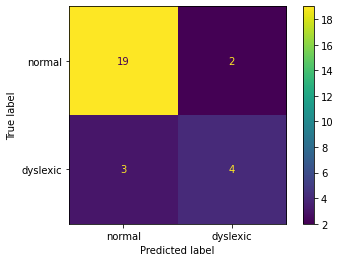

 ari: 0.348  presicion: 0.814  recall:0.821  f1-score: 0.817  auc roc:  0.738  tnr:  0.738 


In [79]:


disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                          display_labels=["normal", "dyslexic"]
                         )



disp.plot()
plt.show()

print(
    f" ari: {ari:.3f} "
    f" presicion: {pre:.3f} "
    f" recall:{rec:.3f} "
    f" f1-score: {fsc:.3f} "
    f" auc roc: {auc_roc: .3f} "
    f" tnr: {tnr.mean(): .3f} "
)


### Hold on a second!


**How good or bad these results are?**


Let us see



In [ ]:


_ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
demo_phono = dd.concat_classes_demo()

# The optimize way to exclude at-risk class
if to_exclude_at_risk == 1:
    to_exclude_at_risk = True
    demo_phono = demo_phono.loc[demo_phono.Group != 2]

demo_old = demo_phono.loc[:, [
    'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
]]

c_features = ['Sex', 'Grade', ]



In [ ]:

demo_old_dys = demo_old.loc[demo_old.Group == 3]

demo_old_dys

In [ ]:


fig = plt.figure(figsize=(19, 13))



gender_old = [len(demo_old['Sex'].loc[demo_old['Sex']==f]) for f in set(demo_old['Sex'])]
gender_old_dys = [len(demo_old_dys['Sex'].loc[demo_old_dys['Sex']==f]) for f in set(demo_old_dys['Sex'])]

gender_new = [len(demo_new['Sex'].loc[demo_new['Sex']==f]) for f in set(demo_new['Sex'])]


gender_new_dys  = [7, 4]



ax = fig.add_subplot(1, 4, 1)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_old, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)
    
plt.title('Old Demo', fontsize=20)


ax = fig.add_subplot(1, 4, 2)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_new, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)


plt.title('New Demo', fontsize=20)



ax = fig.add_subplot(1, 4, 3)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_old_dys, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)


plt.title('Old Dyslexis', fontsize=20)


ax = fig.add_subplot(1, 4, 4)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_new_dys, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)

plt.title('New Dyslexis', fontsize=14)





In [ ]:


old_demo_stat = [213, 22, 72, ]
new_demo_stat = [9, 0, 11, ]


fig = plt.figure(figsize=(19, 13))


ax = fig.add_subplot(1, 2, 1)  # 2 datasets
patches, texts, autotexts = ax.pie(
    x=old_demo_stat, 
    labels=['Normal', 'At-risk', 'Dyslexic'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)
    
plt.title('Old Data', fontsize=20)


ax = fig.add_subplot(1, 2, 2)  # 2 datasets
patches, texts, autotexts = ax.pie(
    x=new_demo_stat, 
    labels=['Normal', 'At-risk', 'Dyslexic'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)

plt.title('New Data', fontsize=20)


plt.show()



# How should we be fair:

- Random selection




sampling_ratio = (72*100)/213
sampling_ratio ~ 33.33%

3 normals 1 dyslexic

In [73]:

dyslexics_idx = np.array([])  # 0, 1, 2, 3, 4, 5, 10, 11, 12, 15, 18, 


dyslexics_idx



array([], dtype=float64)

In [74]:

normal_idx = np.asarray([i for i in range(len(ground_truth)) if ground_truth[i]=='norm'])

normal_idx



array([], dtype=float64)

In [75]:

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False, )



In [ ]:

ROC, PRE, REC, FSC, TNR, ARI = [], [], [], [], [], []


for r in range(10000):
    
    d_idx = np.random.choice(dyslexics_idx, replace=True, size=3)
    n_idx = np.random.choice(normal_idx, replace=True, size=9)
    
    idx = idx = np.concatenate([d_idx, n_idx])
    labels_pred_sampled = [labels_pred[i] for i in idx]
    labels_pred_prob_sampled = [np.max(labels_prob[i, [0, -1]]) for i in idx]
    labels_true_sampled = [labels_true[i] for i in idx]
    
    labels_true_sampled_ = enc.fit_transform(np.asarray(labels_true_sampled).reshape(1, -1))
    
    
    cm = sklearn.metrics.confusion_matrix(
    y_true=labels_true_sampled, 
    y_pred=labels_pred_sampled
    )


    fp = cm.sum(axis=0) - np.diag(cm)
    fn = cm.sum(axis=1) - np.diag(cm)
    tp = np.diag(cm)
    tn = cm.sum() - (fp + fn + tp)
    tnr = tn.astype(float) / (tn.astype(float) + fp.astype(float))
    _, support = np.unique(labels_true_sampled, return_counts=True)
    tnr = tnr.mean()  # np.dot(tnr, support)/sum(support)



    auc_roc = sklearn.metrics.roc_auc_score(
        y_true=labels_true_sampled, 
        y_score=labels_pred_sampled,
        multi_class="ovr",
        average="weighted"
    )




    pre = sklearn.metrics.precision_score(
        labels_true_sampled, labels_pred_sampled, average='weighted'
    )
    rec = sklearn.metrics.recall_score(
        labels_true_sampled, labels_pred_sampled, average='weighted'
    )

    fsc = sklearn.metrics.f1_score(
        labels_true_sampled, labels_pred_sampled, average='weighted'
    )

    ari = sklearn.metrics.adjusted_rand_score(
        labels_true_sampled, labels_pred_sampled
    )
    

    ROC.append(auc_roc)
    PRE.append(pre)
    REC.append(rec)
    FSC.append(fsc)
    TNR.append(tnr)
    ARI.append(ari)
    
#     if r % 505 == 0:
        
#         disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=set(labels_true_sampled)
#                              )



#         disp.plot()
#         plt.show()

#         print(
#             f" ari: {ari:.3f} "
#             f" presicion: {pre:.3f} "
#             f" recall:{rec:.3f} "
#             f" f1-score: {fsc:.3f} "
#             f" auc roc: {auc_roc: .3f} "
#             f" tnr: {tnr: .3f} "
#         )
    

    
    
ROC = np.asarray(ROC)
PRE = np.asarray(PRE)
REC = np.asarray(REC)

FSC = np.asarray(FSC)

TNR = np.asarray(TNR)
ARI = np.asarray(ARI)


In [ ]:


print(
    f" ari: {ARI.mean():.3f} ± {ARI.std():.3f} \n"
    f" presicion: {PRE.mean():.3f} ± {PRE.std():.3f} \n"
    f" recall: {REC.mean():.3f} ± {REC.std():.3f} \n"
    f" f1-score: {FSC.mean():.3f} ± {FSC.std():.3f} \n"
    f" auc roc: {ROC.mean(): .3f} ± {ROC.std(): .3f} \n"
    f" tnr: {TNR.mean(): .3f} ± {TNR.std(): .3f} \n"
)




# Feature importance 



In [76]:

explainer = shap.Explainer(mdl.predict, x_test, feature_names=list(x_org.columns))



In [77]:


shap_values = explainer(x_test)



Permutation explainer: 1001it [00:32, 21.79it/s]                                                                                                                                  


In [78]:


print("Shap values are determined!")




Shap values are determined!


In [79]:


y_test.shape, x_test.shape, shap_values.values.shape




((1000,), (1000, 17), (1000, 17))

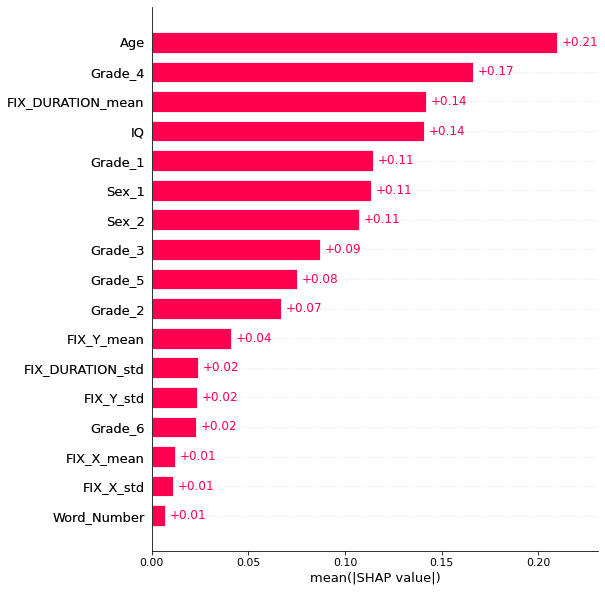

In [80]:



shap.plots.bar(shap_values, max_display=99, show=False)
# plt.gcf()
# plt.savefig("plots/bar.png")





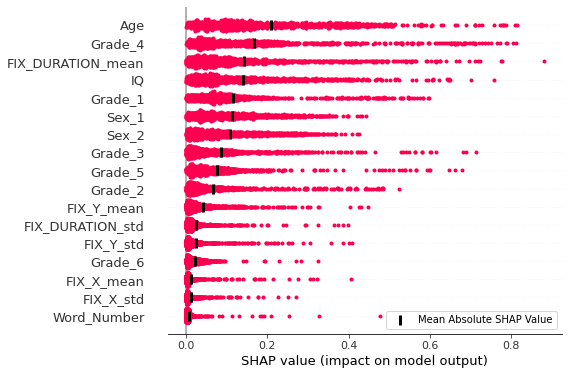

In [81]:


plt.gcf()
shap.plots.bar(shap_values.abs.max(0), max_display=99, show=False)
plt.subplot(2, 1, 2)
shap.plots.beeswarm(
    shap_values.abs, color="shap_red", max_display=99, show=False, plot_size=None
)
ax = plt.gca()
masv = {}

for feature in ax.get_yticklabels():
    name = feature.get_text()
    col_ind = x_org.columns.get_loc(name)
    mean_abs_sv = np.mean(np.abs(shap_values.values[:, col_ind]))
    masv[name] = mean_abs_sv
ax.scatter(
    masv.values(),
    [i for i in range(len(x_org.columns))],
    zorder=99,
    label="Mean Absolute SHAP Value",
    c="k",
    marker="|",
    linewidths=3,
    s=100,
)
ax.legend(frameon=True)
plt.tight_layout()


# plt.savefig("plots/bar_beeswarm.png")





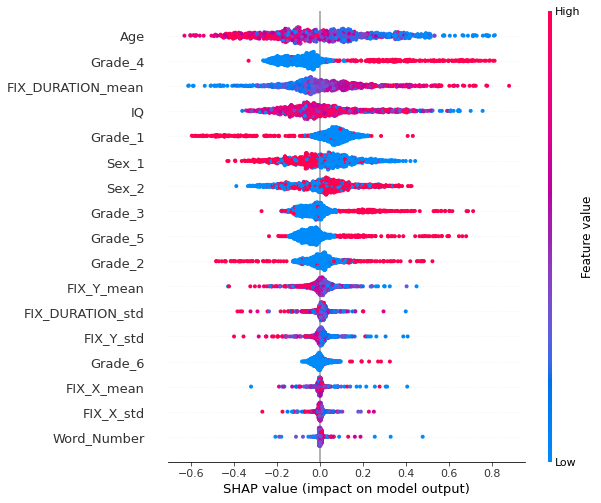

In [82]:


shap.summary_plot(shap_values=shap_values.values, 
                  features=x_test,
                  class_names=["Norm", "at-risk", "Dyslexic"],
                  feature_names=list(x_org.columns), 
                 )




FixedFormatter should only be used together with FixedLocator


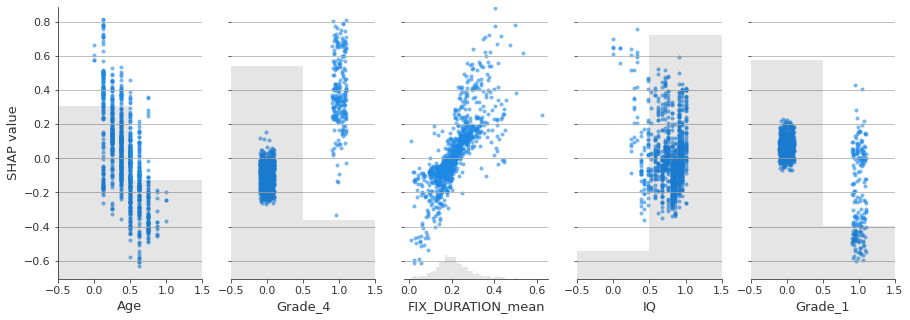

In [83]:

n = 5
fig, ax = plt.subplots(1, n, figsize=(15, 5))

for i, (k, v) in enumerate(sorted(masv.items(), key=lambda x: x[1], reverse=True)):
    if i < n:
        shap.plots.scatter(shap_values[:, k], ax=ax[i], show=False, alpha=0.6)
        ax[i].grid(axis="y")
        if i != 0:
            ax[i].set_ylabel("")
            ax[i].spines["left"].set_visible(False)
            ax[i].set_ylim(ax[0].get_ylim())
            ax[i].set_yticklabels(["" for _ in range(len(ax[0].get_yticks()))])
        else:
            ax[i].set_ylabel("SHAP value")
# fig.savefig("plots/scatter_top5.png")




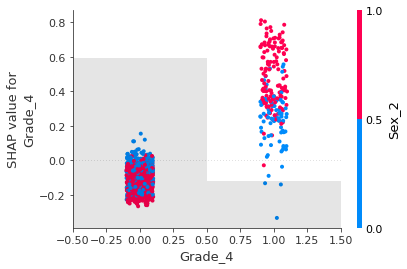

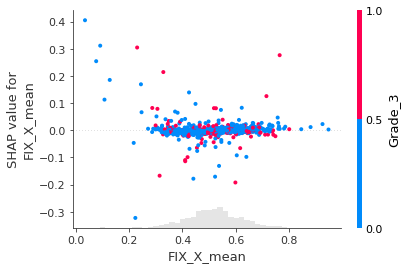

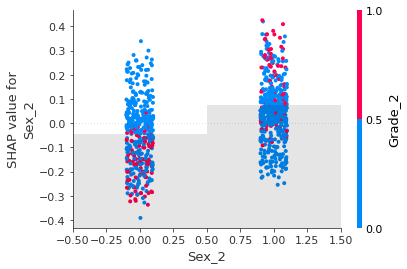

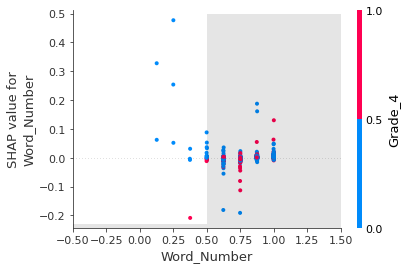

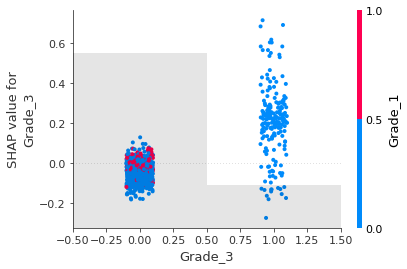

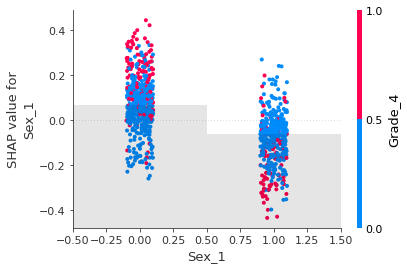

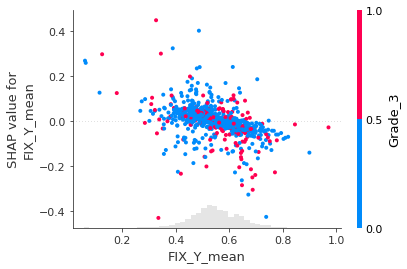

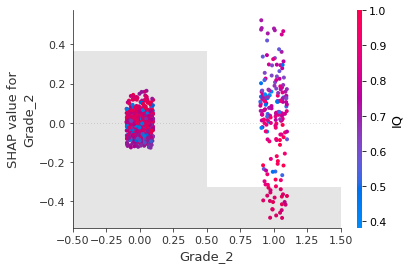

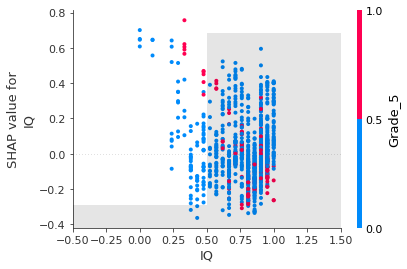

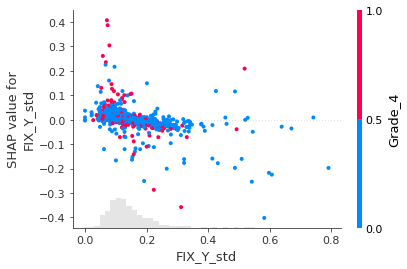

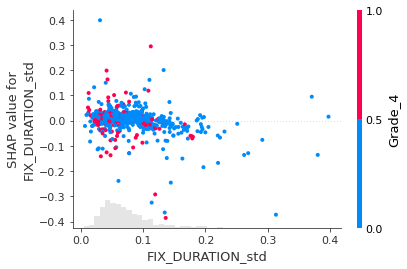

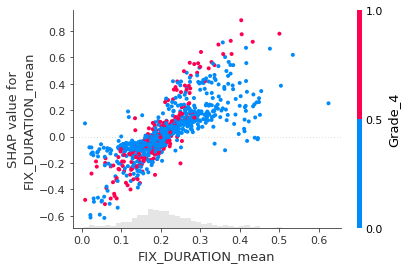

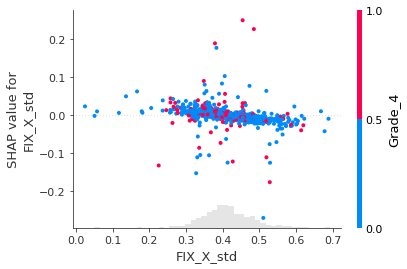

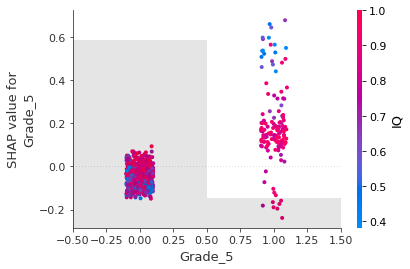

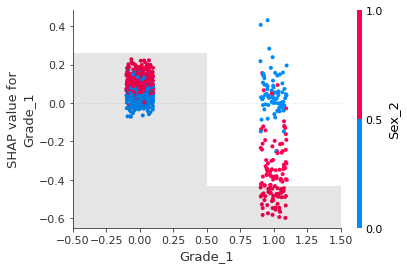

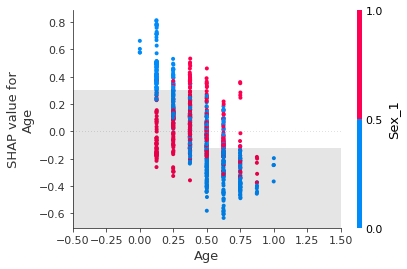

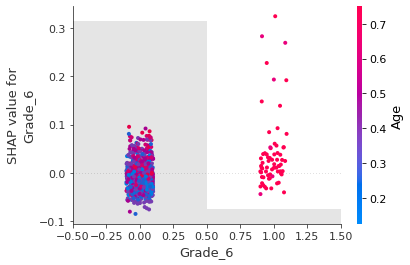

In [84]:


for i in range(x_test.shape[1]):
    fig, ax = plt.subplots()
    shap.plots.scatter(shap_values[:, i], color=shap_values, ax=ax)


